<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.855 · Modelos avanzados de minería de datos · PEC2</p>
<p style="margin: 0; text-align:right;">2022-1 · Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PEC 2: Métodos no supervisados

**Importante: la entrega debe contener el notebook (.ipynb) y su HTML tras la completa ejecución secuencial (.html) donde se pueda ver el código y los resultados. Para exportar el notebook a HTML puedes hacerlo desde el menú File → Download as → HTML.**

A lo largo de esta práctica veremos como aplicar distintas técnicas no supervisadas
así como algunas de sus aplicaciones reales:

 - **[Clustering con distintas estrategias](#ej1)**: k-means y regla del codo, basadas en densidad y jerárquicas.
 - **[Ejemplo práctico: diseño de redes de transporte](#ej2)**: clustering y análisis.

<div class="alert alert-block alert-info">
<strong>Nombre y apellidos: Gerson Villalba Arana</strong>
</div>

---

Para ello vamos a necesitar las siguientes librerías:

In [1]:
import random

import haversine as hs
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn import cluster        # Algoritmos de clustering.
from sklearn import datasets       # Crear datasets.
from sklearn import decomposition  # Algoritmos de reduccion de dimensionalidad.
import smopy
import tqdm

import kruskal

%matplotlib inline

<a id="ej1"></a>

## 1. Métodos de *clustering* (5 puntos)

Este ejercicio trata de explorar distintas técnicas de agrupamiento ajustándolas a distintos conjuntos de datos.

El objetivo es doble: entender la influencia de los parámetros en su comportamiento, y conocer sus limitaciones en la búsqueda de estructuras de datos.

### Generación de los conjuntos de datos

In [2]:
X_blobs, y_blobs = datasets.make_blobs(n_samples=1000, n_features=2, centers=4, cluster_std=1.6, random_state=42)
X_moons, y_moons = datasets.make_moons(n_samples=1000, noise=.07, random_state=42)
X_circles, y_circles = datasets.make_circles(n_samples=1000, factor=.5, noise=.05, random_state=42)

Cada dataset tiene 2 variables: una variable *X* que contiene 2 features (columnas) y tantas filas como muestras. Y una variable *y* que alberga las etiquetas que identifican cada cluster.

A lo largo del ejercicio no se usará la variable *y* (sólo con el objetivo de visualizar). El objetivo es a través de los distintos modelos de *clustering* conseguir encontrar las estructuras descritas por las variables *y*.

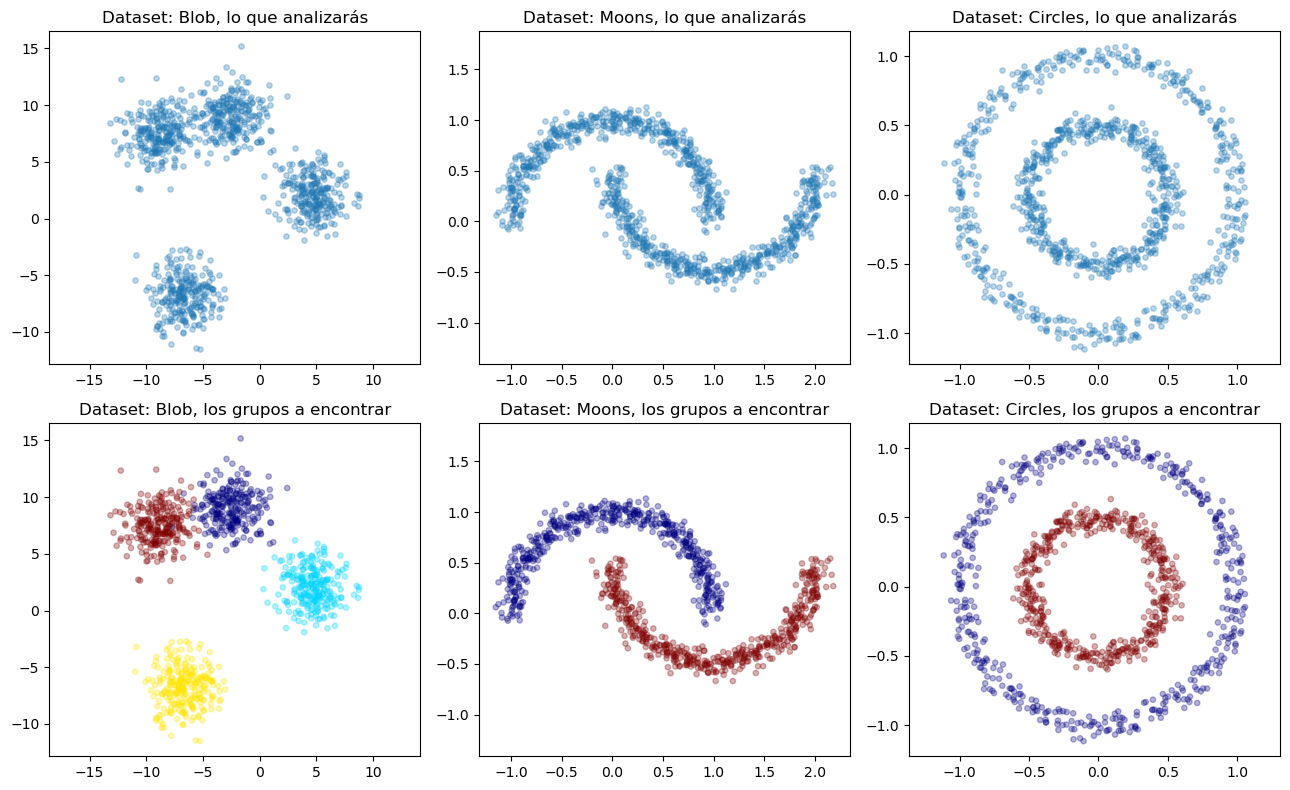

In [3]:
fig, axis = plt.subplots(2, 3, figsize=(13, 8))
for i, (X, y, ax, name) in enumerate(zip([X_blobs, X_moons, X_circles] * 2,
                                         [None] * 3 + [y_blobs, y_moons, y_circles],
                                         axis.reshape(-1),
                                         ['Blob', 'Moons', 'Circles'] * 2)):
    ax.set_title('Dataset: {}, '.format(name) + ('lo que analizarás' if i < 3 else 'los grupos a encontrar'))
    ax.scatter(X[:,0], X[:,1], s=15, c=y, alpha=.3, cmap='jet')
    ax.axis('equal')
plt.tight_layout()

### 1 a. K-means

En este apartado se pide probar el algoritmo *k-means* sobre los tres datasets presentados anteriormente ajustando con los parámetros adecuados y analizar sus resultados.

In [4]:
X, y = X_blobs, y_blobs

Para estimar el número de clusters a detectar por *k-means*. Una técnica para estimar $k$ es, como se explica en la teoría:
> Los criterios anteriores (minimización de distancias intra grupo o maximización de distancias inter grupo) pueden usarse para establecer un valor adecuado para el parámetro k. Valores k para los que ya no se consiguen mejoras significativas en la homogeneidad interna de los segmentos o la heterogeneidad entre segmentos distintos, deberían descartarse.

Lo que popularmente se conocer como *regla del codo*.

Primero es necesario calcular la suma de los errores cuadráticos ([*SSE*](https://bl.ocks.org/rpgove/0060ff3b656618e9136b)) que consiste en la suma de todos los errores (distancia de cada punto a su centroide asignado) al cuadrado.

$$SSE = \sum_{i=1}^{K} \sum_{x \in C_i} euclidean(x, c_i)^2$$

Donde $K$ es el número de clusters a buscar por *k-means*, $x \in C_i$ son los puntos que pertenecen a i-ésimo cluster, $c_i$ es el centroide del cluster $C_i$ (al que pertenece el punto $x$), y $euclidean$ es la [distancia euclídea](https://en.wikipedia.org/wiki/Euclidean_distance).

Este procedimiento realizado para cada posible valor $k$, resulta en una función monótona decreciente, donde el eje $x$ representa los distintos valores de $k$, y el eje $y$ el $SSE$. Intuitivamente se podrá observar un significativo descenso del error, que indicará el valor idóneo de $k$.

**Se pide realizar la representación gráfica de la regla del codo junto a su interpretación, utilizando la librería ```matplotlib``` y la implementación en scikit-learn de [*k-means*](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).**

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> cálculo y visualización de la regla del codo en el dataset Blobs.
</div>

In [5]:
import seaborn as sns

In [6]:
# Set Seaborn aesthetics
plt.rcParams["figure.figsize"] = (5,5)
plt.rcParams['lines.linewidth'] = 2
plt.style.use('ggplot')

In [7]:
def plot_elbow_kmeans(X, max_clusters=10):
    distortions  = []
    cluster_list = list(range(1,max_clusters+1))
    for n_clusters in cluster_list:
        k_means = cluster.KMeans(n_clusters=n_clusters, random_state=41).fit(X)
        distortions.append(k_means.inertia_)
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot(cluster_list, distortions)
    ax.set_xlabel('Number of clusters')
    ax.set_ylabel('SSE')
    ax.set_title('KMeans (Elbow rule)', fontsize=14)
    plt.show()

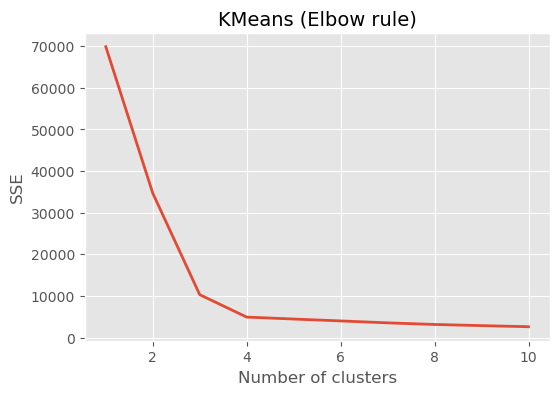

In [8]:
plot_elbow_kmeans(X, 10)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué se interpreta en la gráfica? ¿Cómo podría mejorarse la elección de $k$?.  
</div>

Se puede ver por la gráfica cómo el SSE se reduce en una cantidad enorme hasta los 3 clusters, pero de los 3 a los 4 también hay una reducción significativa del SSE, a partir del cual esta reducción es mínima. Según la regla del codo con el SSE, elegiríamos pues el valor de k igual a 4 como óptimo, que en este caso coincide con el número de *blobs* que hemos generado.

La elección de la k con el método *elbow* utilizando el SSE puede llegar a ser bastante arbitraria. Una opción es utilizar otras métricas como el coeficiente *silhouette*, que calculamos a continucación.

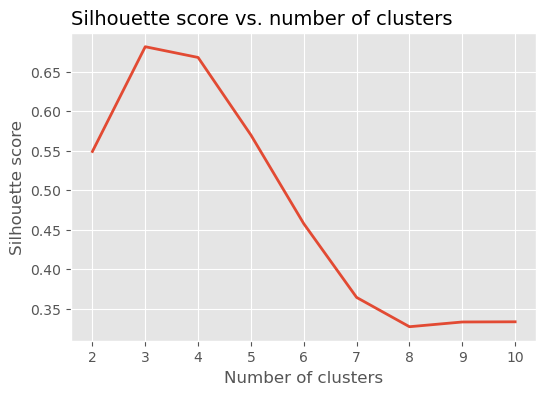

In [9]:
from sklearn.metrics import silhouette_score


def plot_silhouette(X, max_clusters=10):
    silhouette = []
    cluster_list = list(range(2,max_clusters+1))
    for n_clusters in cluster_list:
        k_means = cluster.KMeans(n_clusters=n_clusters, random_state=41).fit(X)
        silhouette.append(silhouette_score(X, k_means.labels_))
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot(cluster_list, silhouette)
    ax.set_xlabel('Number of clusters')
    ax.set_ylabel('Silhouette score')
    ax.set_title('Silhouette score vs. number of clusters', fontsize=14, loc='left')
    plt.show()
    
    
plot_silhouette(X, 10)

El coeficiente silhouette es bastante más costoso computacionalmente, pero suele ser más claro a la hora de determinar el número de clusters óptimo, ya que se toma el número de clusters en el que este toma el valor máximo. Para este caso estaríamos también dudando entre elegir k=3 o k=4, que tienen un valor parecido, y es lo mismo que habíamos determinado con el SSE.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> cálculo y visualización de los grupos en el dataset Blobs.
</div>

In [10]:
def plot_clusters_kmeans(X, n_clusters):
    k_means = cluster.KMeans(n_clusters=n_clusters, random_state=41)
    classes = k_means.fit_predict(X)
    colors = ['#E24A33', '#348ABD', '#FBC15E', '#8EBA42']
    df_centroids = pd.DataFrame(k_means.cluster_centers_, columns=['x', 'y'])
    df_centroids['cluster'] = range(n_clusters)
    fig, ax = plt.subplots()
    sns.scatterplot(x=X[:,0], y=X[:,1], hue=classes, alpha=0.5, palette=colors[:n_clusters], ax=ax)
    sns.scatterplot(x='x', y='y', hue='cluster', data=df_centroids, marker='X', s=120, edgecolor='k', palette=colors[:n_clusters], ax=ax, legend=False)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    ax.set_title('KMeans (Cluster representation)', fontsize=14)
    plt.show()

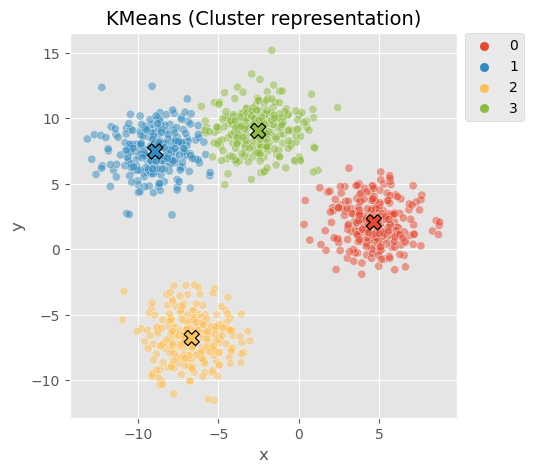

In [11]:
plot_clusters_kmeans(X, 4)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado. 
</div>

Con este dataset podemos ver cómo el clustering realizado por kmeans es adecuado de acuerdo a los grupos que teníamos que encontrar. Hay puntos que no se asignan al cluster que pertenecían inicialmente, especialmente entre los clusters 1 y 3, ya que éstos están bastante juntos. Sin embargo, podemos ver como la regla general es que se realiza una separación bastante buena de lus clusters iniciales.

In [12]:
X, y = X_moons, y_moons

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> cálculo y visualización de la regla del codo en el dataset Moons.
</div>

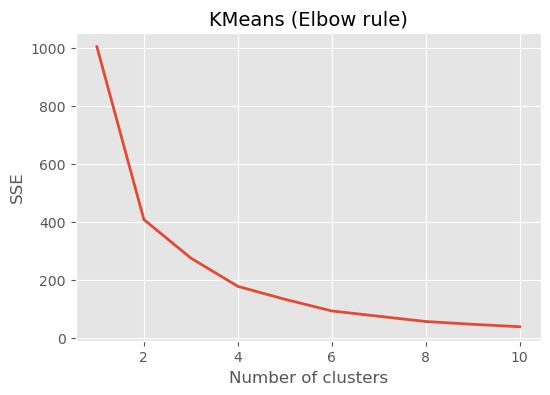

In [13]:
plot_elbow_kmeans(X)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué se interpreta en la gráfica? ¿Cómo podría mejorarse la elección de $k$?.  
</div>

En este caso la regla del codo no nos da unos resultados demasiado clarificadores, lo que nos lleva a pensar que quizás este método no es el más adecuado para el dataset que tenemos. Vemos como a partir de 2 clusters el descenso del SSE es cada vez menor, pero no termina de estabilizarse en un punto a partir del cual ya no mejore apenas. Si tuviésemos que elegir un número a partir de exclusivamente esta información, quizás sería el de 4 clusters nuevamente, porque a partir de este punto la pendiente de bajada es algo menor.

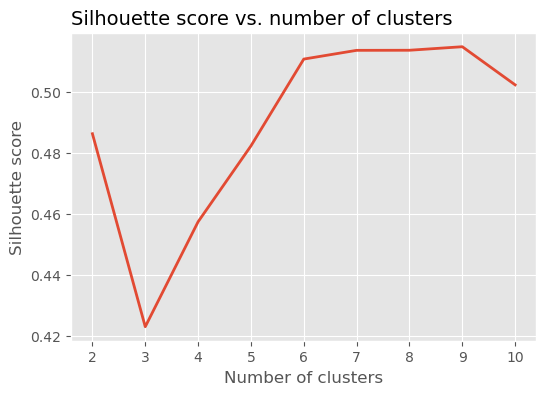

In [14]:
plot_silhouette(X, 10)

Mirando el coeficiente silhouette tomaríamos un número de clusters entre 6 y 9, pero tampoco queda demasiado claro, lo que lleva a pensar nuevamente que este algoritmo no sea adecuado para este caso.

Como en este caso, sin embargo, contamos con la información adicional de que el número de clusters es de dos (porque así hemos generado los datos), utilizamos esta número para generar los clusters.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> cálculo y visualización de los grupos en el dataset Moons.
</div>

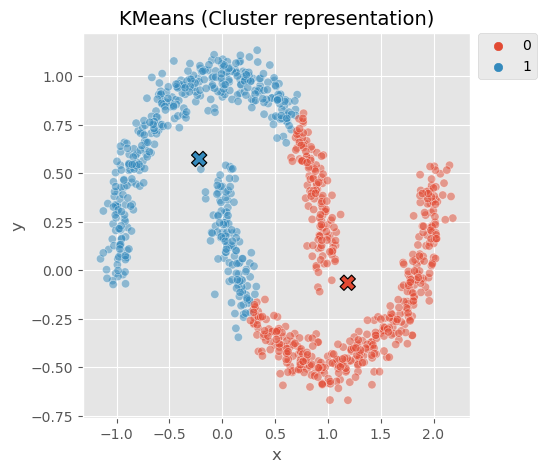

In [15]:
plot_clusters_kmeans(X, 2)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.  
</div>

Vemos claramente como a pesar de haber dividido los datos en dos clusters, estos no siguen la forma que deberían teniendo en cuenta la concentración de puntos y la asignación inicial que teníamos en dos clusters. Podemos concluir que para este dataset no es adecuada la utilización de KMeans. Esto se debe a que este algoritmo se basa exclusivamente en la distancia entre puntos para determinar cuales pertenecen a un mismo cluster, método que en este caso con nubes de puntos no circulares claramente no es adecuado.

In [16]:
X, y = X_circles, y_circles

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> cálculo y visualización de la regla del codo en el dataset Circles.
</div>

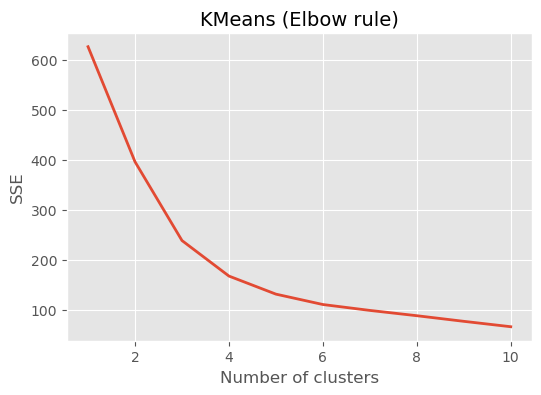

In [17]:
plot_elbow_kmeans(X)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué se interpreta en la gráfica? ¿Cómo podría mejorarse la elección de $k$?.  
</div>

Nos ocurre algo similar al caso anterior, donde no podemos determinar claramente un número k óptimo de clusters, ya que el SSE no tiene un punto claro de estabilización. Si tuviésemos que elegir un número en base a esta información, quizá estaría entre el 4 y 5.

Sin embargo, igual que pasaba antes, tenemos la información adicional de partida de que existen dos clusters, por lo que utilizaremos este número.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> cálculo y visualización de los grupos en el dataset Circles.
</div>

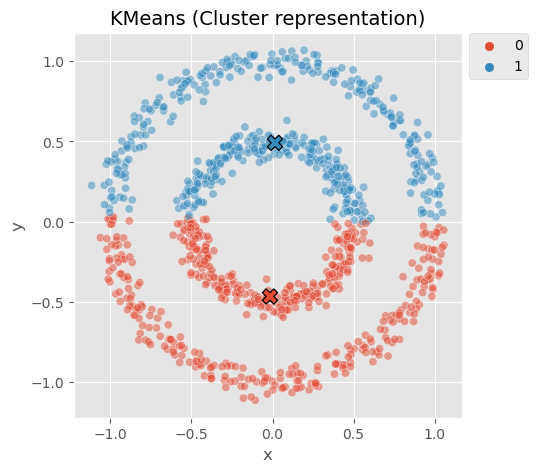

In [18]:
plot_clusters_kmeans(X, 2)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.  
</div>

Tenemos un problema similar al caso anterior. Claramente hay dos clusters en los datos, pero KMeans no es capaz de capturarlos adecuadamente por su funcionamiento basado exclusivamente en distancias. Tanto en este caso como en el anterior, sería más adecuado utilizar un algoritmo basado en densidad.

### 1 b. Algoritmos basados en densidad: DBSCAN

En este apartado se pide aplicar clustering por densidad como [DBSCAN](https://en.wikipedia.org/wiki/DBSCAN) a los datasets anteriores para detectar los dos grupos subyacentes.

Ésta es una visualización intuitiva de su funcionamiento: https://www.youtube.com/watch?v=RDZUdRSDOok

In [19]:
X, y = X_blobs, y_blobs

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> prueba la implementación de <a href="http://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html">DBSCAN en scikit-learn</a> jugando con los parámetros <i>eps</i> y <i>min_samples</i> para encontrar los grupos (y <i>outliers</i>) del dataset Blobs.
</div>

In [20]:
def plot_clauster_dbscan(X, eps, min_samples):
    db = cluster.DBSCAN(eps=eps, min_samples=min_samples).fit(X)
    labels = db.labels_
    if -1 in labels:
        n_clusters = len(set(labels)) - 1
        colors = ['#777777', '#E24A33', '#348ABD', '#FBC15E', '#8EBA42', '#FFB5B8']
    else:
        n_clusters = len(set(labels))
        colors = ['#E24A33', '#348ABD', '#FBC15E', '#8EBA42', '#FFB5B8']
    fig, ax = plt.subplots()
    sns.scatterplot(x=X[:,0], y=X[:,1], hue=labels, alpha=0.5, palette=colors[:len(set(labels))], ax=ax)
    ax.set_title(f'DBSCAN with eps={eps}, min_samples={min_samples} -> {n_clusters} clusters', fontsize=12)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.show()

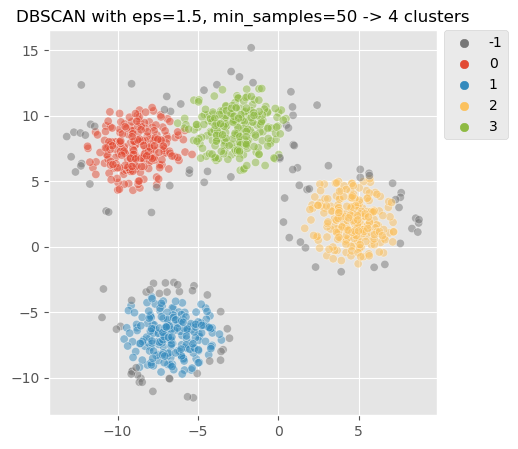

In [21]:
plot_clauster_dbscan(X, 1.5, 50)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.  
</div>

Con el algoritmo DBSCAN podemos realizar el clustering en los cuatro clusters originales que teníamos. Sin embargo, existen diferencias con KMeans: 
* No hemos especificado de forma explícita el número de clusters, sino los parámetros *eps* y *min_samples*. El no tener que especificar el número de clusters puede ser una ventaja, pero requiere experiencia y paciencia especificar correctamente estos otros dos parámetros para realizar un clustering adecuado. Ha requerido un tiempo probar con diferentes valores de estos dos parámetros para realmente realizar un clustering adecuado.
* Ahora tenemos puntos que no son asignados a ningún cluster y que son catalogados como *outliers* (clase -1 en la gráfica). Como en nuestro caso los *blobs* tienen una densidad de puntos mayor en los centros, no tiene problema en agrupar estos puntos en su correspondiente cluster. Sin embargo, los puntos más al borde no los agrupa en el mismo cluster. Este es uno de los problemas de DBSCAN, que es muy sensible a cambios en la densidad de puntos dentro de un cluster.

Por lo tanto, para este primer caso, el agrupamiento KMeans funcionaría mejor, ya que no dejaría como outliers elementos que en realidad no lo son.

Podemos evitar la asignación de tantos outliers modificando los parámetros, pero en ese caso nos encontraremos con que dos de los clusters (los que se encuentran más próximos) se han unido, dejando sólo 3 clusters en lugar de los 4 que sabemos de antemano que hay.

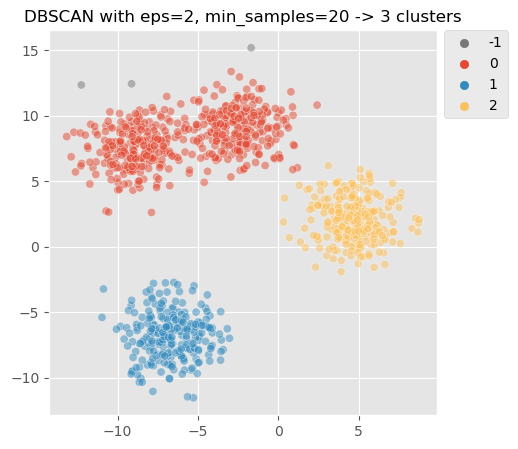

In [22]:
plot_clauster_dbscan(X, 2, 20)

In [23]:
X, y = X_moons, y_moons

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> prueba la implementación de DBSCAN jugando con los parámetros <i>eps</i> y <i>min_samples</i> para encontrar los grupos (y <i>outliers</i>) del dataset Moons.
</div>

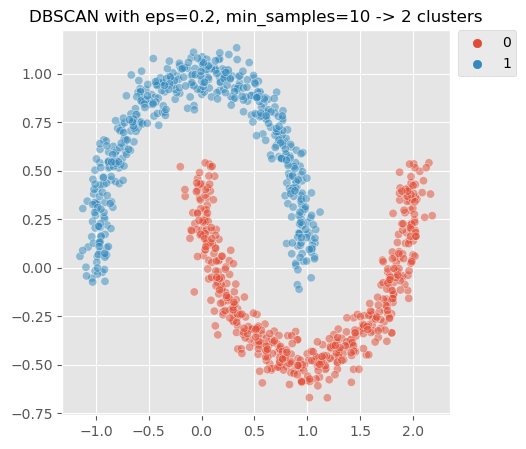

In [24]:
plot_clauster_dbscan(X, 0.2, 10)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.  
</div>

Con unos valores adecuados de *eps* y *min_samples*, podemos obtener una agurpación perfecta en dos clusters, los mismos dos que teníamos en origen. No hemos especificado el número de clusters, pero el propio algoritmo ha detectado que son dos. Por otro lado, en este caso todos los puntos los asigna a uno de ambos clusters y ninguno lo categoriza como outlier, ya que las nubes de puntos son suficientemente densas y están suficientemente separadas entre ellas. Además, ha sido más sencillo elegir los parámetros de DBSCAN (hay más rango de valores que funciona correctamente), porque realmente fijándonos en la densidad de puntos ambos clusters están claramente separados.

In [25]:
X, y = X_circles, y_circles

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> prueba la implementación de DBScan jugando con los parámetros <i>eps</i> y <i>min_samples</i> para encontrar los grupos (y <i>outliers</i>) del dataset Circles.
</div>

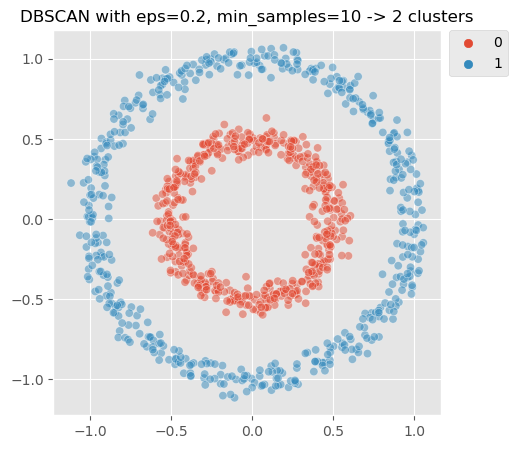

In [26]:
plot_clauster_dbscan(X, 0.2, 10)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.  
</div>

Los resultados son muy similares a los obtenidos en el apartado anterior. Con unos valores adecuados de *eps* y *min_samples*, podemos obtener una agurpación perfecta en dos clusters, los mismos dos que teníamos en origen. Tampoco tenemos ningún valor categorizado como outlier, ya que las nubes de puntos son suficientemente densas y están suficientemente separadas entre ellas.

### 1 c. Algoritmos jerárquicos

En este apartado se pide visualizar mediante un [dendrograma](https://en.wikipedia.org/wiki/Dendrogram) la construcción progresiva de los grupos mediante un algoritmo jerárquico aglomerativo (estrategia *bottom-up*). Con ello se pretende encontrar un método gráfico para entender el comportamiento del algoritmo y encontrar los *clusters* deseados en cada dataset.

In [27]:
X, y = X_blobs, y_blobs

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> prueba la implementación de <a href="https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html">clustering jerárquico de scipy</a> probando distintos <a href="https://en.wikipedia.org/wiki/Hierarchical_clustering#Linkage_criteria">criterios de enlace o <i>linkage</i></a> permitiendo identificar los clusters subyacentes (mostrando su resultado) y su dendrograma para el dataset Blobs.<br>
Puedes importar las librerías necesarias para ello.
</div>

In [28]:
from scipy.cluster import hierarchy

def plot_dendograms(X):
    for link in ['single', 'complete', 'average', 'centroid']:
        Z = hierarchy.linkage(X, method=link, metric='euclidean', optimal_ordering=False)
        fig, ax = plt.subplots(figsize=(25, 10))
        dn = hierarchy.dendrogram(Z)
        ax.set_title(f'Dendogram with {link} linkage', fontsize=14, loc='left')
        plt.show()

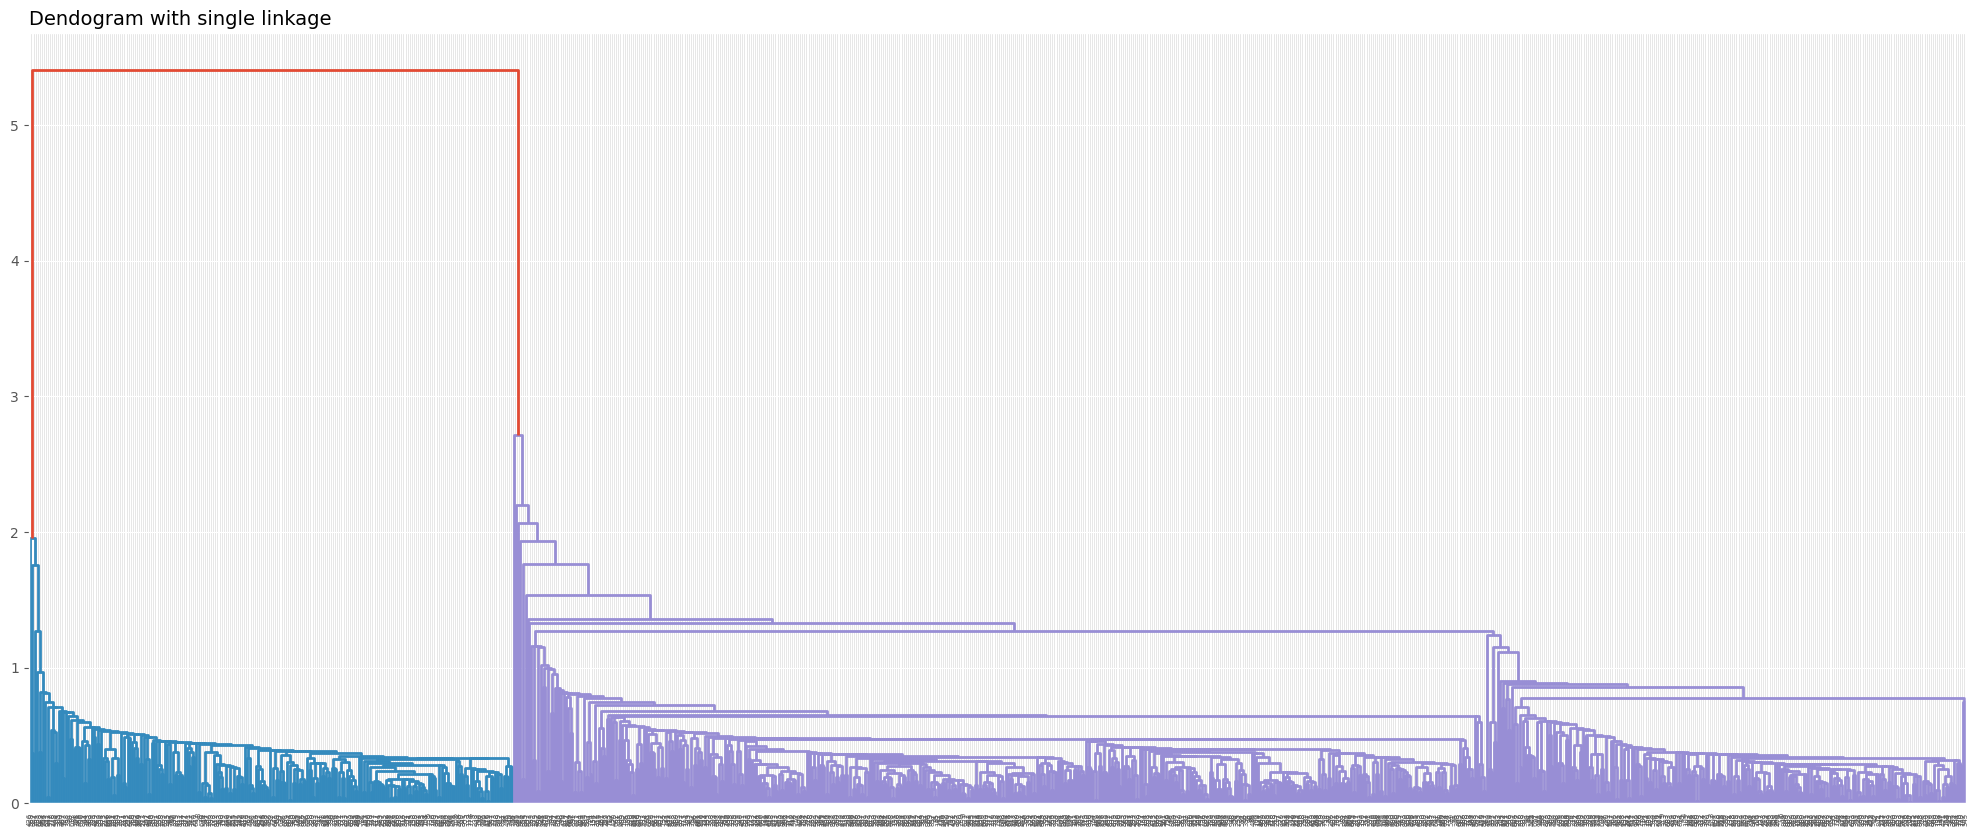

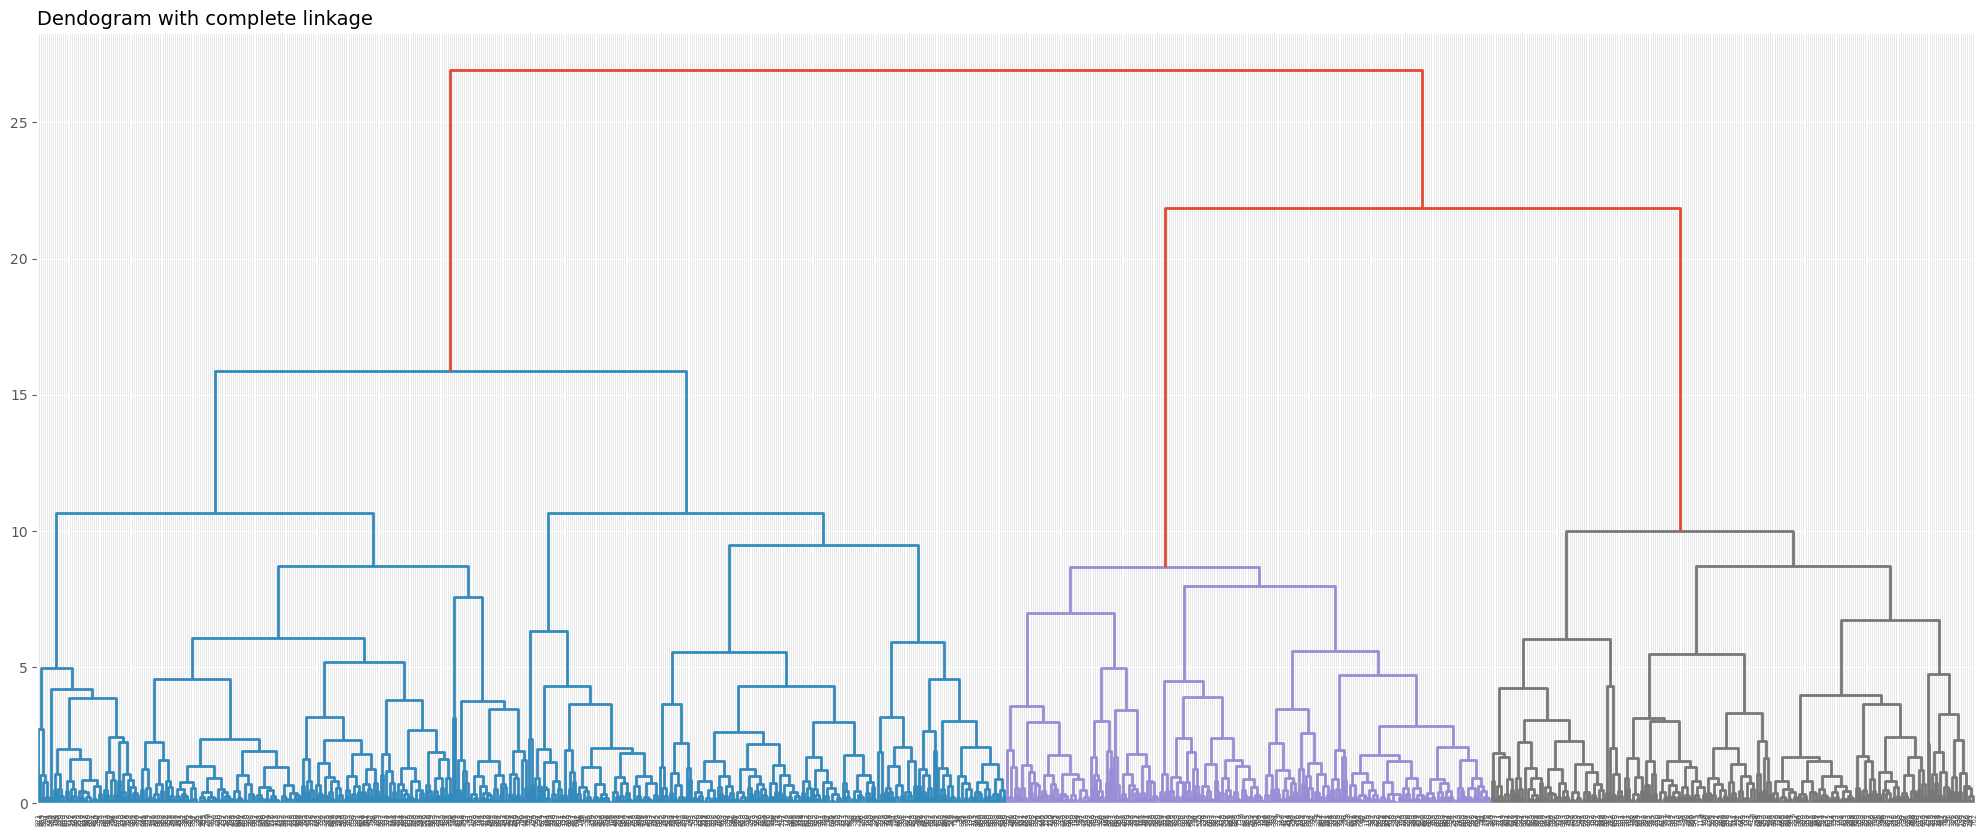

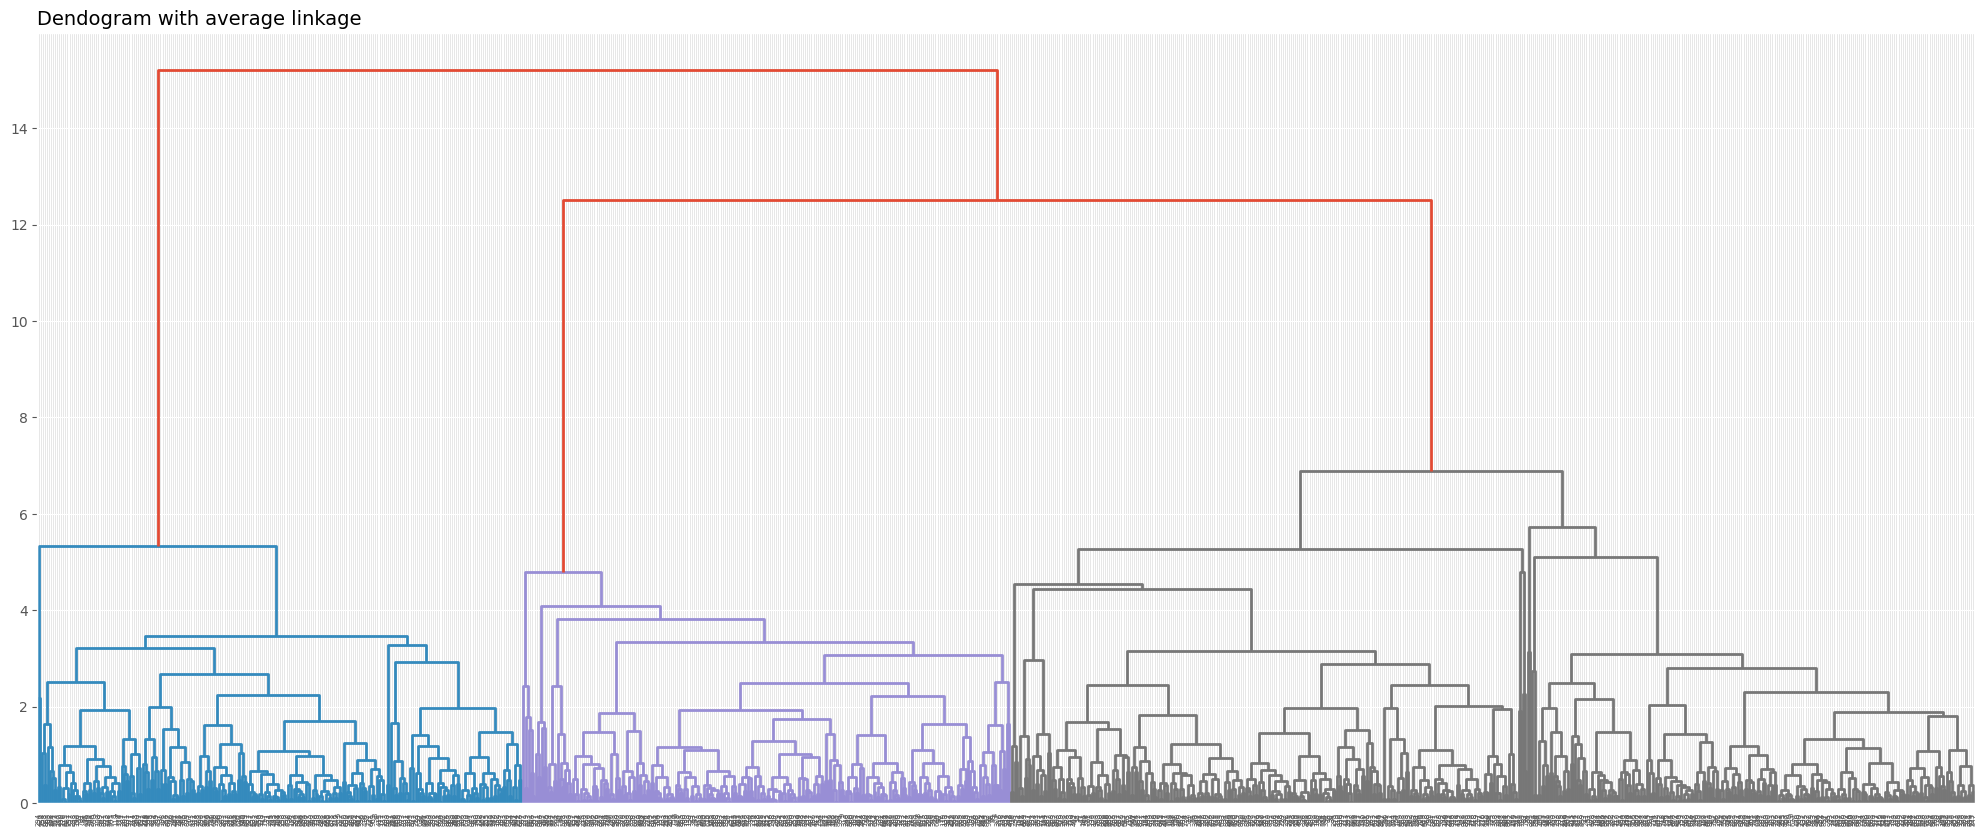

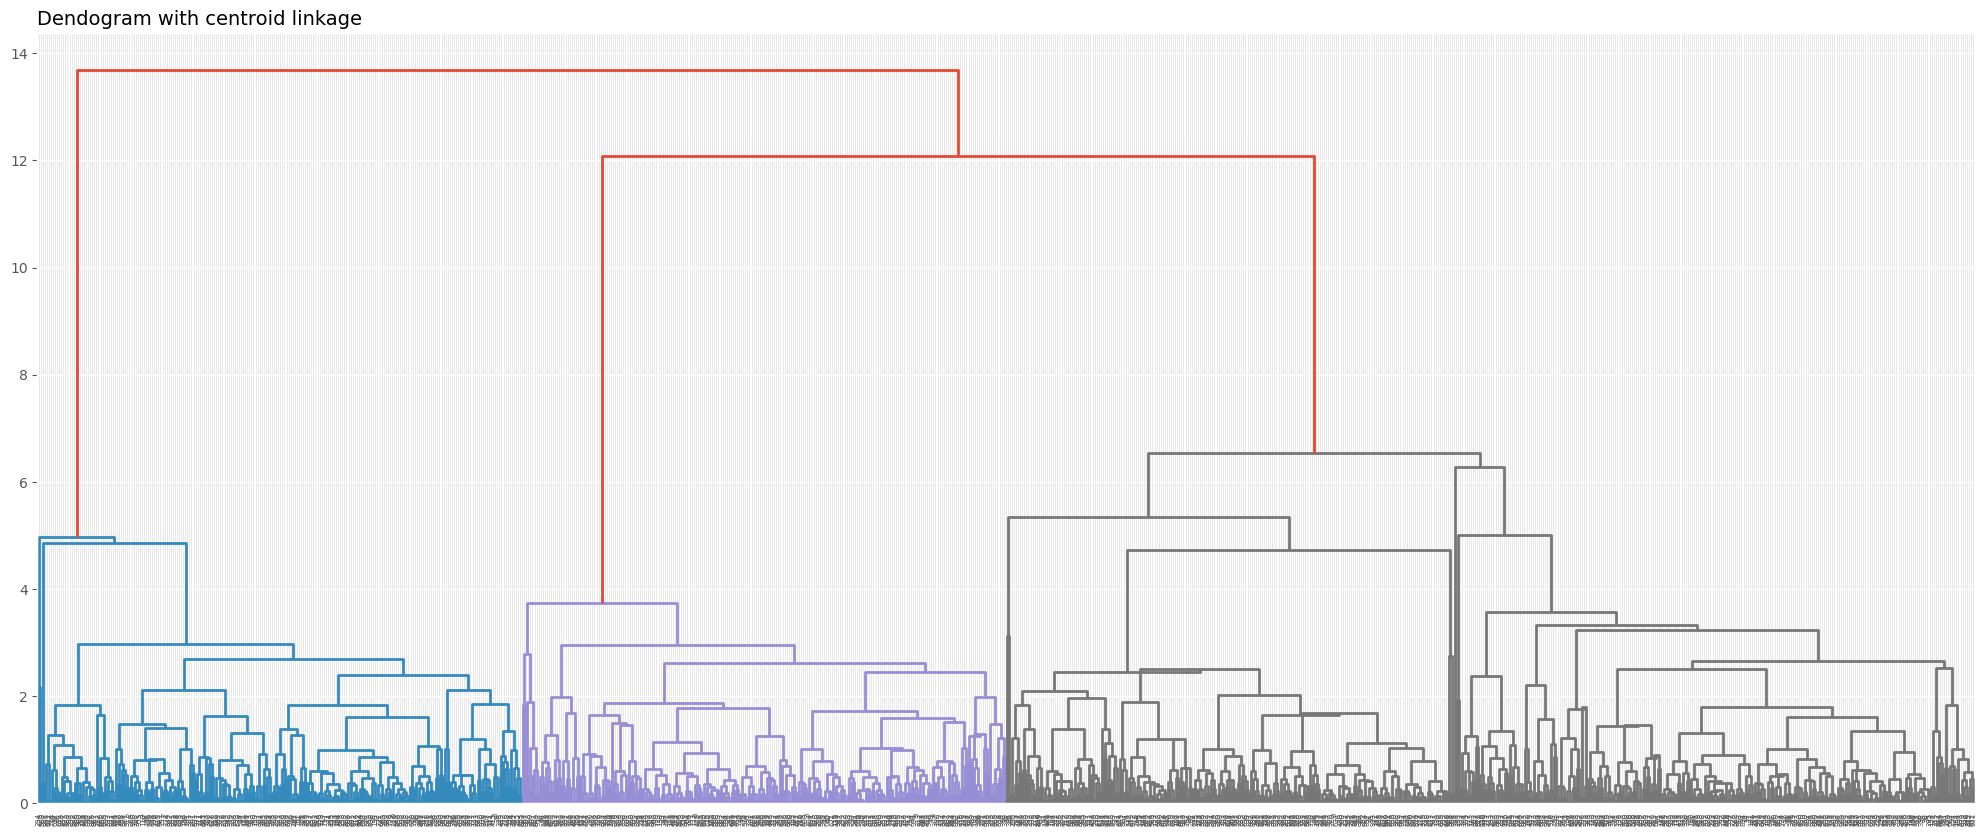

In [29]:
plot_dendograms(X)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> Interpreta el dendrograma y comenta qué criterio de enlace se ha comportado mejor. ¿Por qué?
</div>

Hemos probado cuatro tipos de *linkage*:
* Enlace simple: Tiene en cuenta la distancia mínima entre elementos de dos clusters.
* Enlace completo: Tiene en cuenta la distancia máxima entre elementos de dos clusters.
* Enlace medio: Tiene en cuenta la distancia media entre elementos de dos clusters.
* Enlace centroide: Tiene en cuanta la distancia entre los centroides de dos clusters.

Podemos ver cómo el método simple (single) da unos resultados extraños, ya que al tomar sólamente la distancia mínima sólo uno de los clusters se identifica claramente del resto, creandose dos clusters claros. Esto es debido a que los otros tres clusters originales comparten algún punto en común muy cercano entre ellos, de foma que con este método estos clusters se encuentran demasido cerca para ser diferenciados.

Con el método simple tenemos unos resultados con mucho más sentido. Podemos ver claramente cómo podríamos dividir en tres (tomando la división de la primera rama izquierda, la de los dos clusters que están más cercanos) o cuatro clusters (tomando sólamente las primera división de la derecha).

Por último, los métodos de enlace medio y enlace centroide arrojan resultados similares, y con ambos casos parece claro que el agrupamiento debería ser en 3 clusters, ya que la distancia con el resto de divisiones es muy grande. En todo caso, es un resultado que tiene sentido teniendo en cuenta que dos de los clústers originales están muy cercanos, y por lo tanto no está tan claro que sean dos. 

En base a los resultados, por lo tanto, el método más óptimo en este caso es el de enlace completo, ya que nos permite distinguir más claramente los cuatro clusters originales.

In [30]:
X, y = X_moons, y_moons

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>
prueba la implementación de <a href="https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html">clustering jerárquico de scipy</a> probando distintos <a href="https://en.wikipedia.org/wiki/Hierarchical_clustering#Linkage_criteria">criterios de enlace o <i>linkage</i></a> permitiendo identificar los clusters subyacentes (mostrando su resultado) y su dendrograma para el dataset Moons.<br>
Puedes importar las librerías necesarias para ello.
</div>

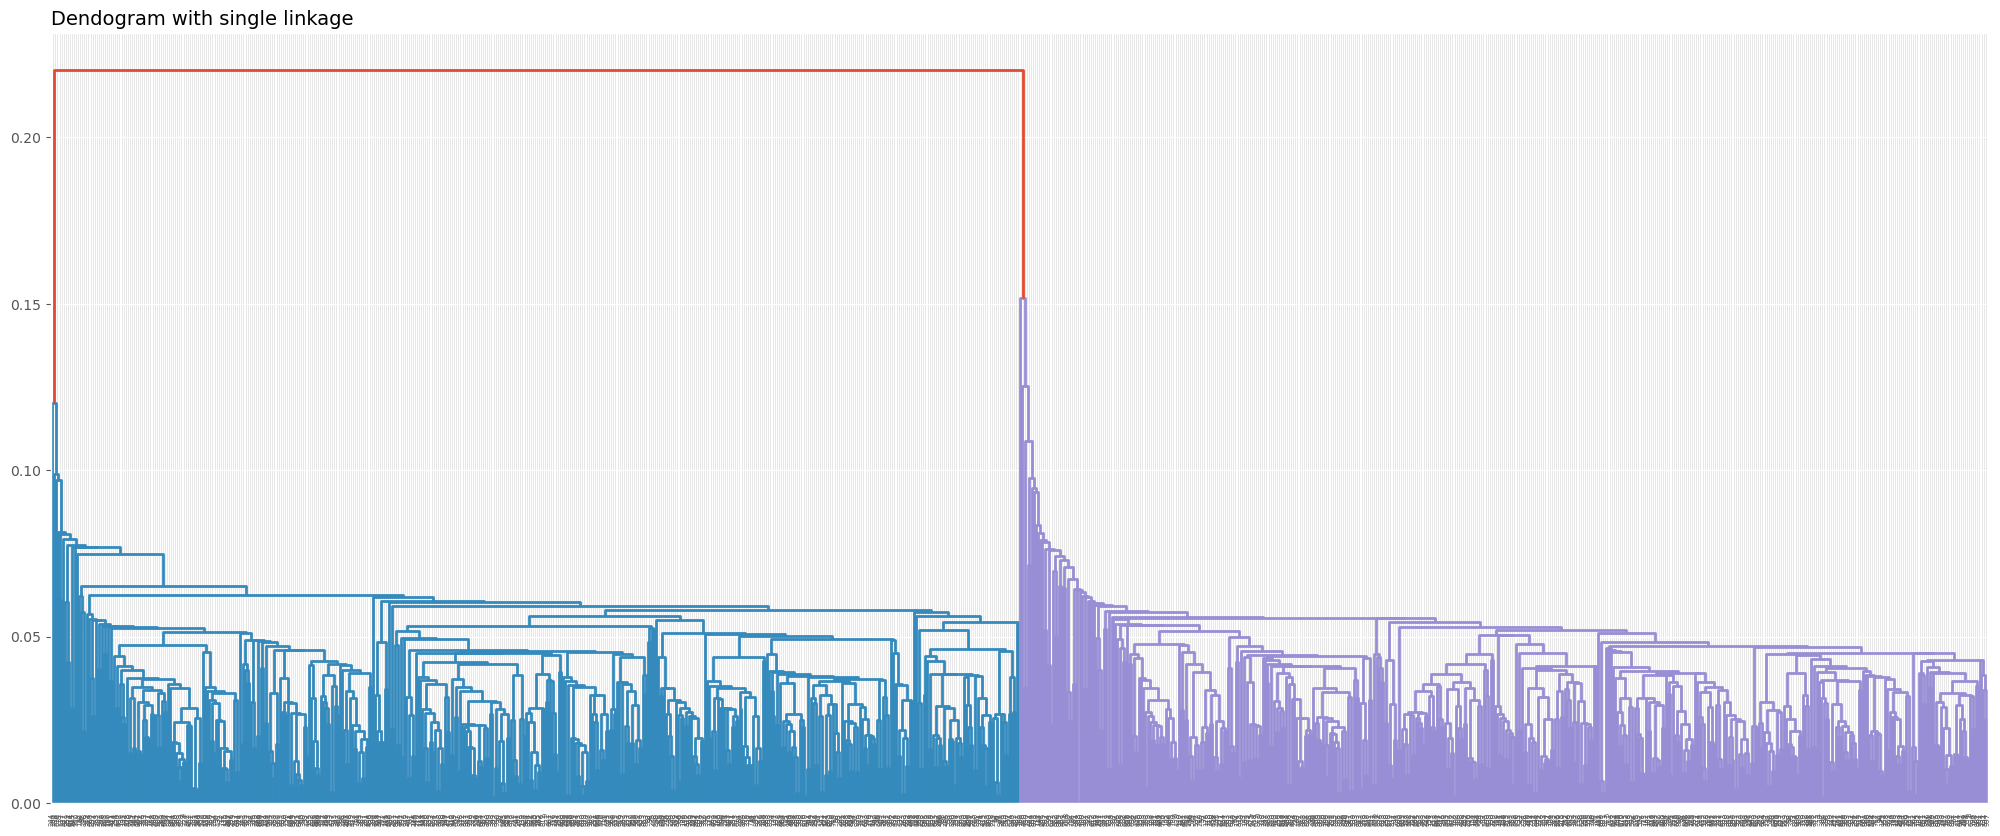

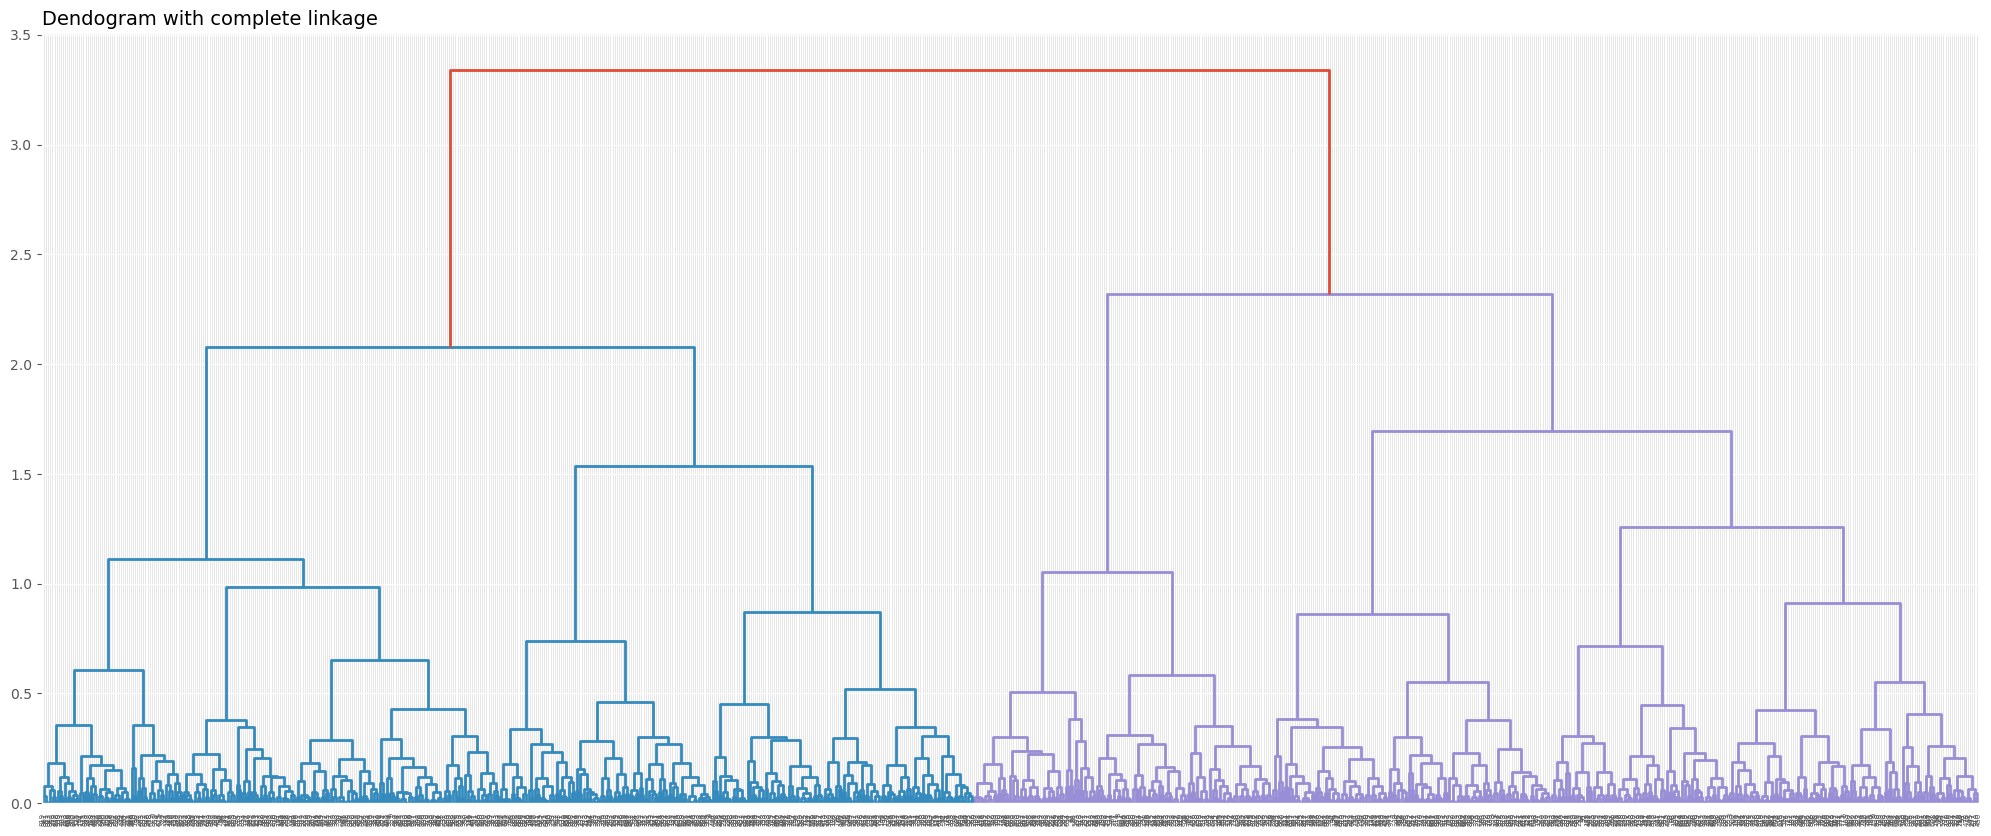

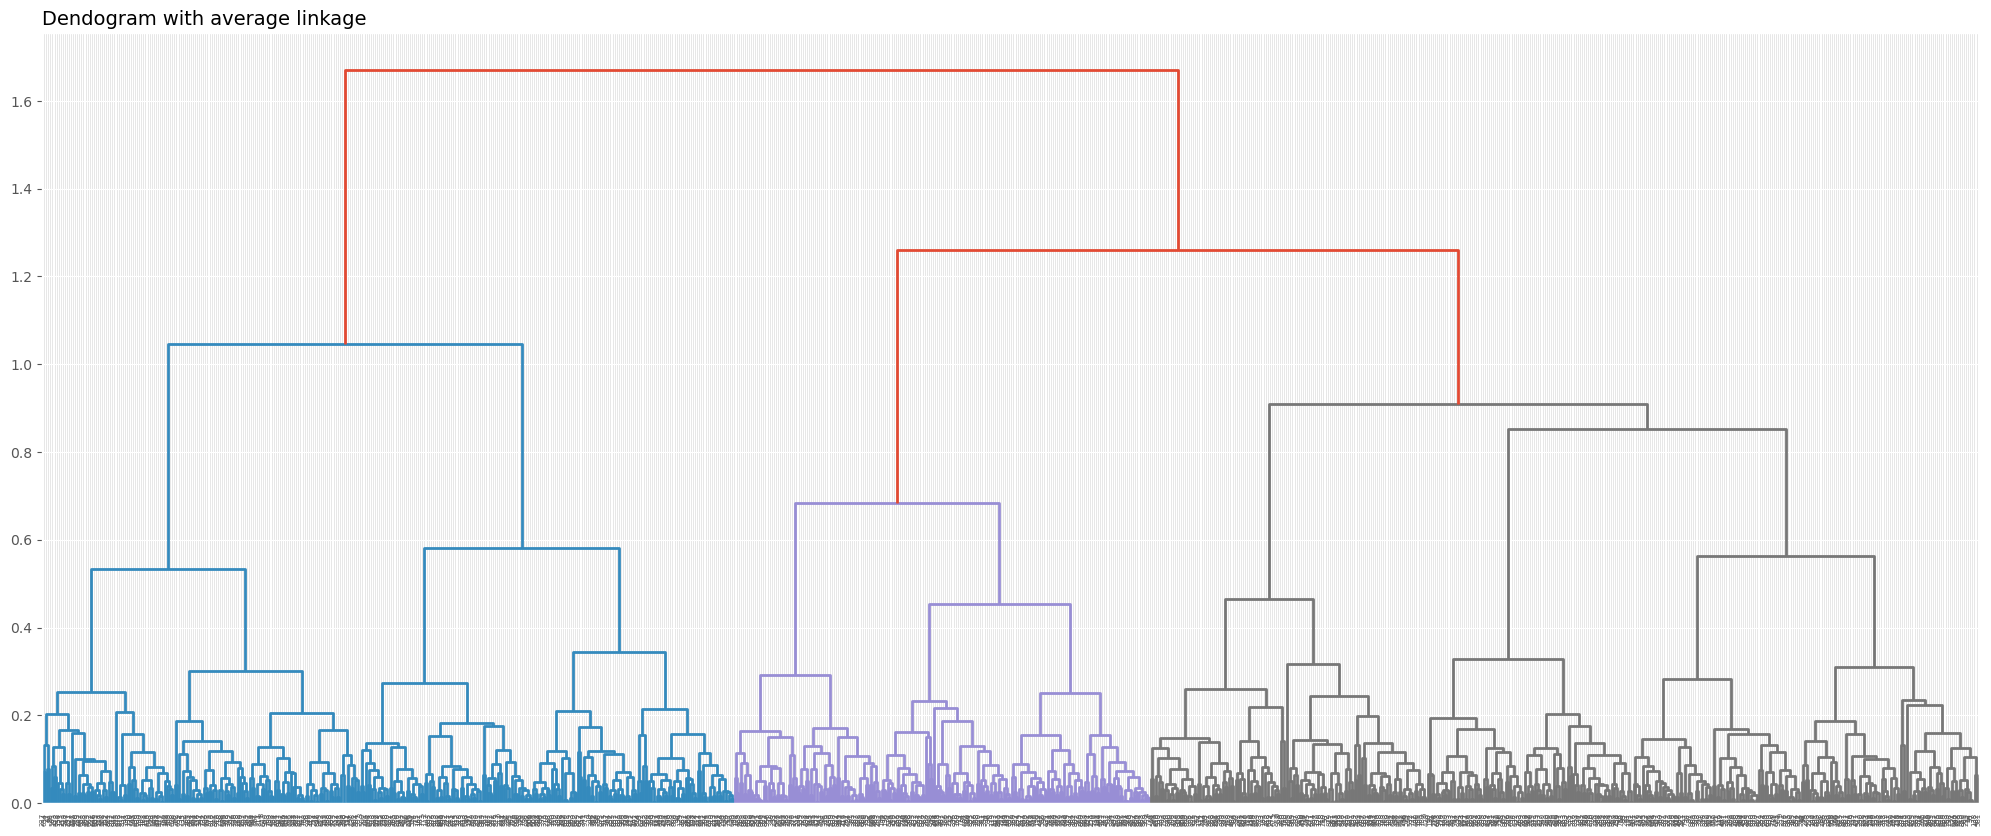

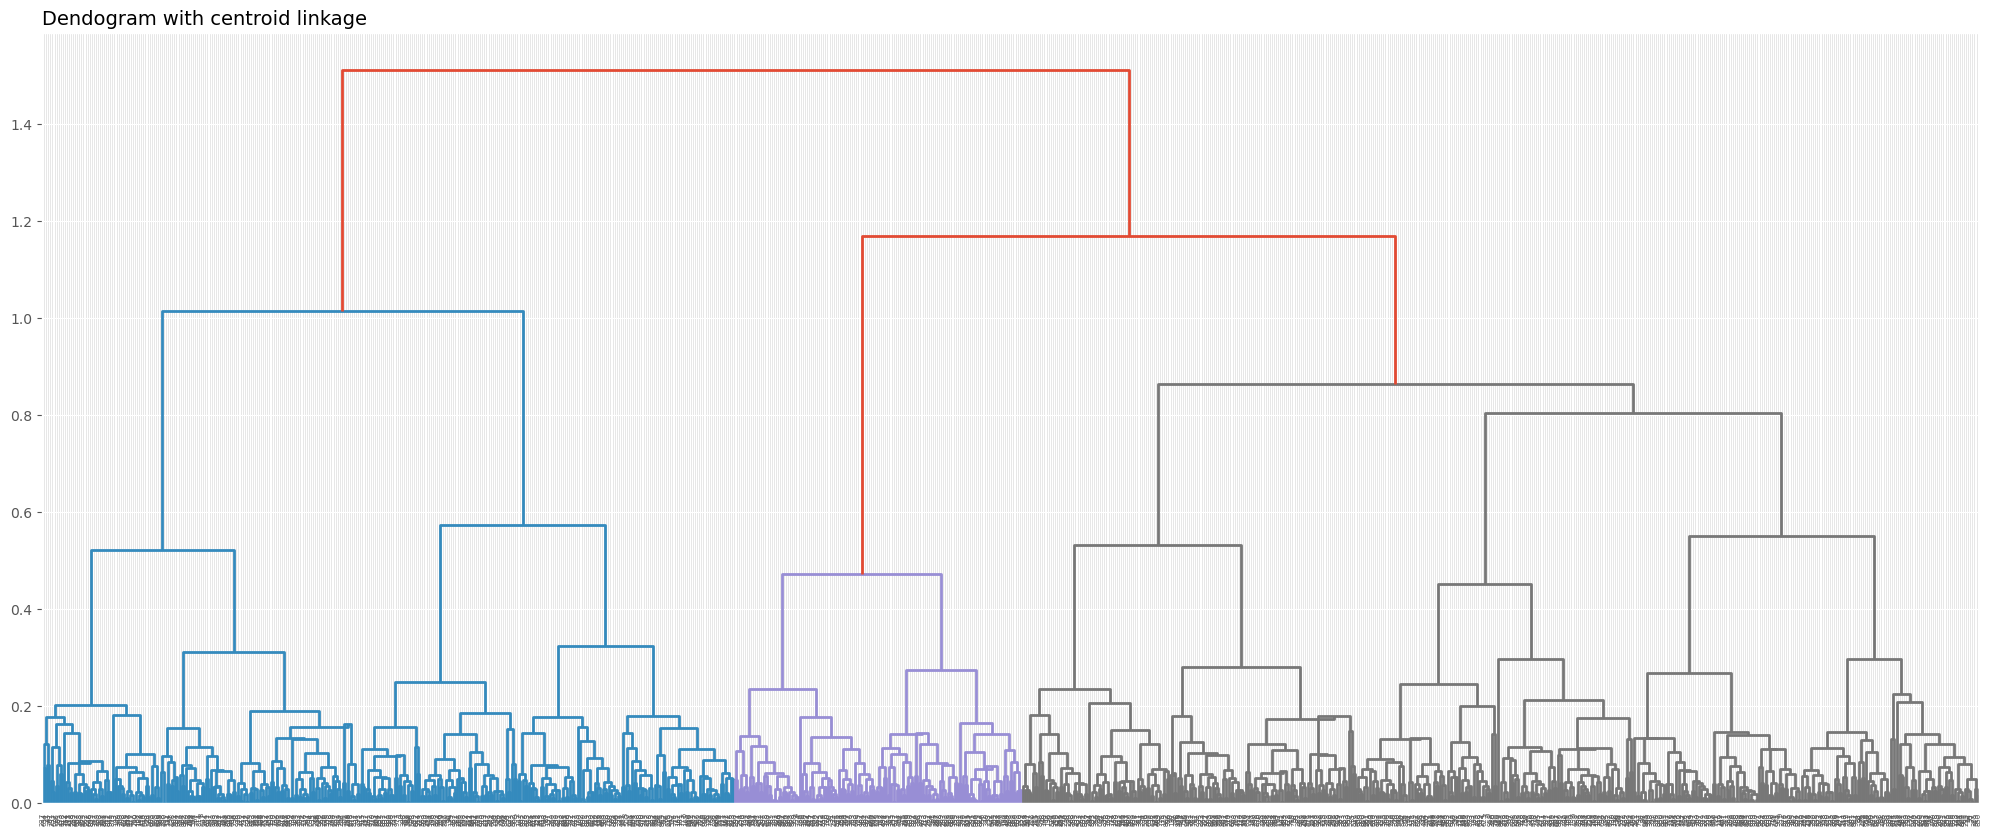

In [31]:
plot_dendograms(X)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> Interpreta el dendrograma y comenta qué criterio de enlace se ha comportado mejor. ¿Por qué?
</div>

En este caso hemos probado los mismos criterios de enlace que en el caso anterior, pero podemos ver que los resultados son muy distintos. Al no tener los clusters sus elementos al rededor de un punto central, sino con una forma arbitraria, los resultados son muy distintos. Vemos que en este caso el método que mejor resultado nos da para distinguer los dos clusters iniciales es el de enlace simple. Al tener dos clusters muy densos y muy separados entre ellos, la distancia mínima de dos elementos de clusters distintos es muy alta entre los dos clusters originales, y por ello la separación en estos dos es muy clara en el primer dendograma. El resto de tipos de enlace dan en este caso unos resultados similares, y en ninguno de ellos vemos el número claro de clusters en los que deberíamos dividir.

In [32]:
X, y = X_circles, y_circles

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>
prueba la implementación de <a href="https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html">clustering jerárquico de scipy</a> probando distintos <a href="https://en.wikipedia.org/wiki/Hierarchical_clustering#Linkage_criteria">criterios de enlace o <i>linkage</i></a> permitiendo identificar los clusters subyacentes (mostrando su resultado) y su dendrograma para el dataset Circles.<br>
Puedes importar las librerías necesarias para ello.
</div>

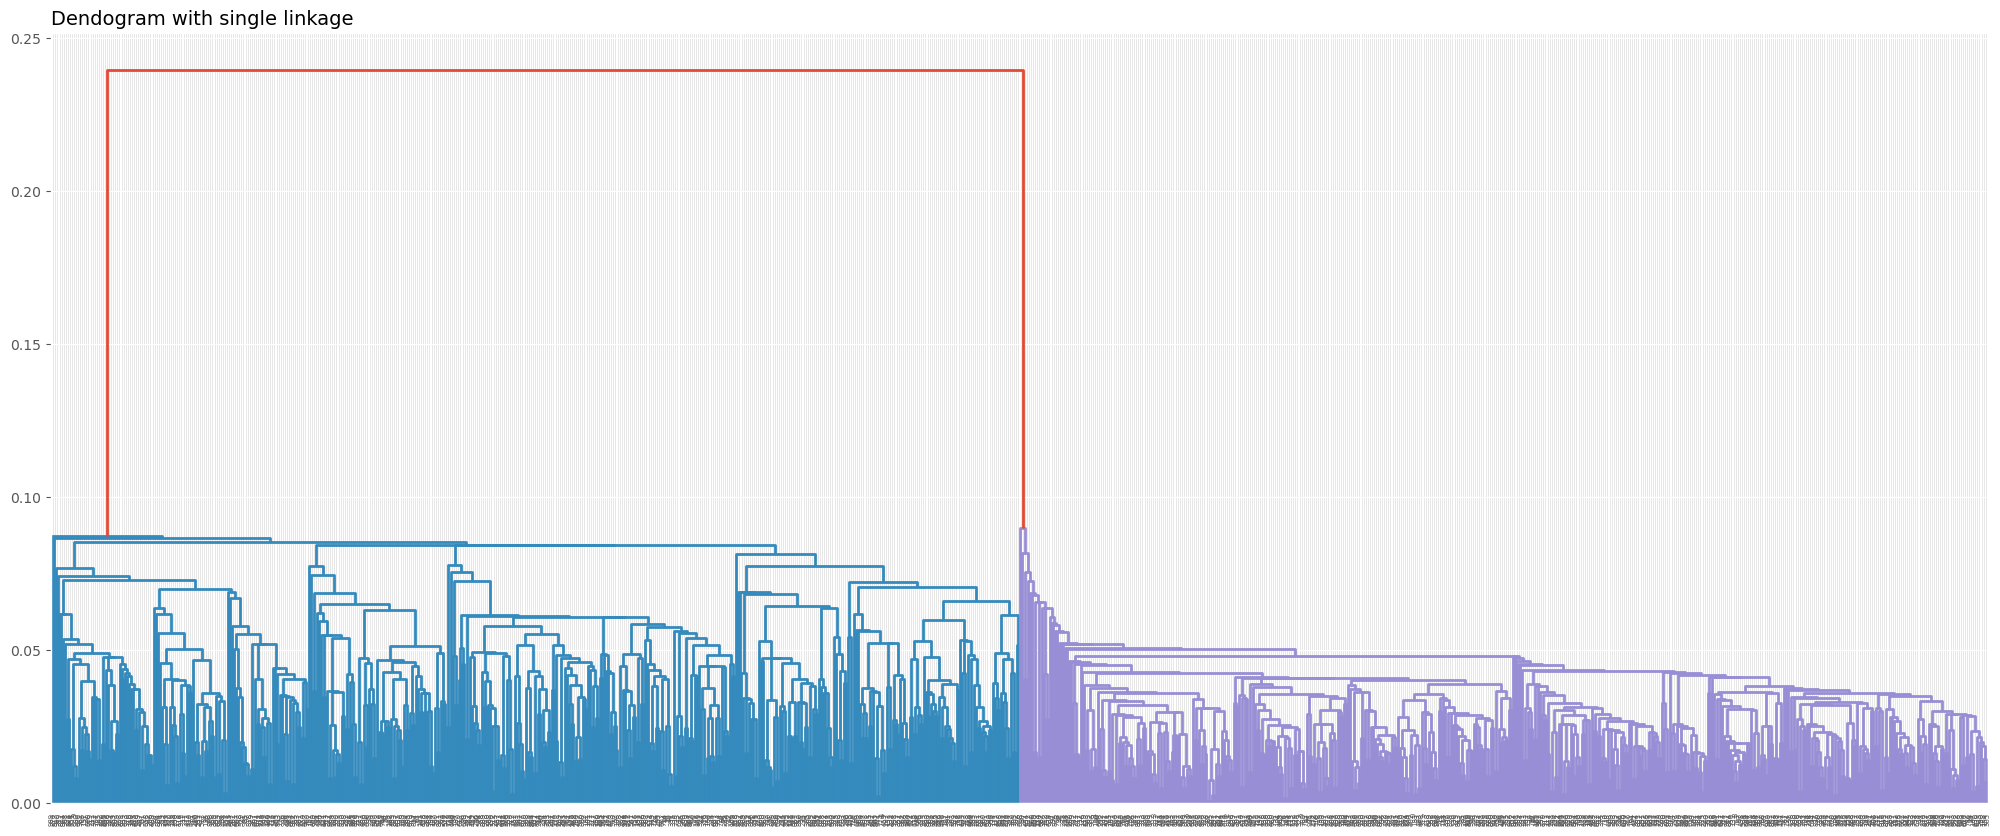

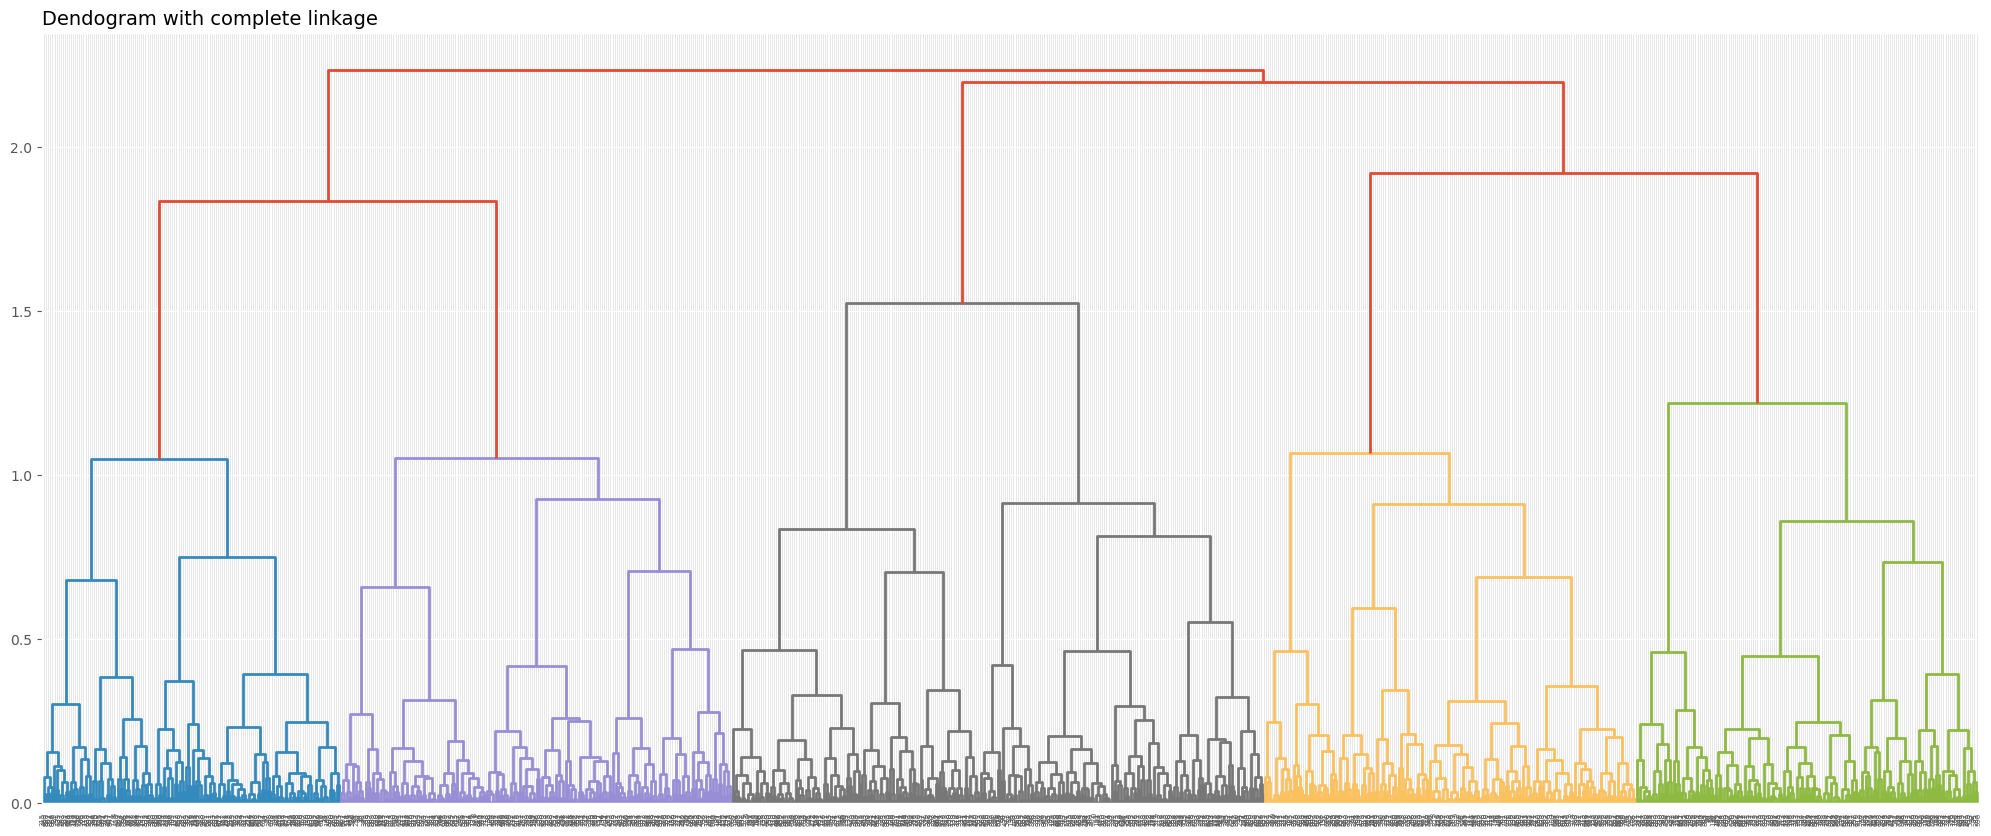

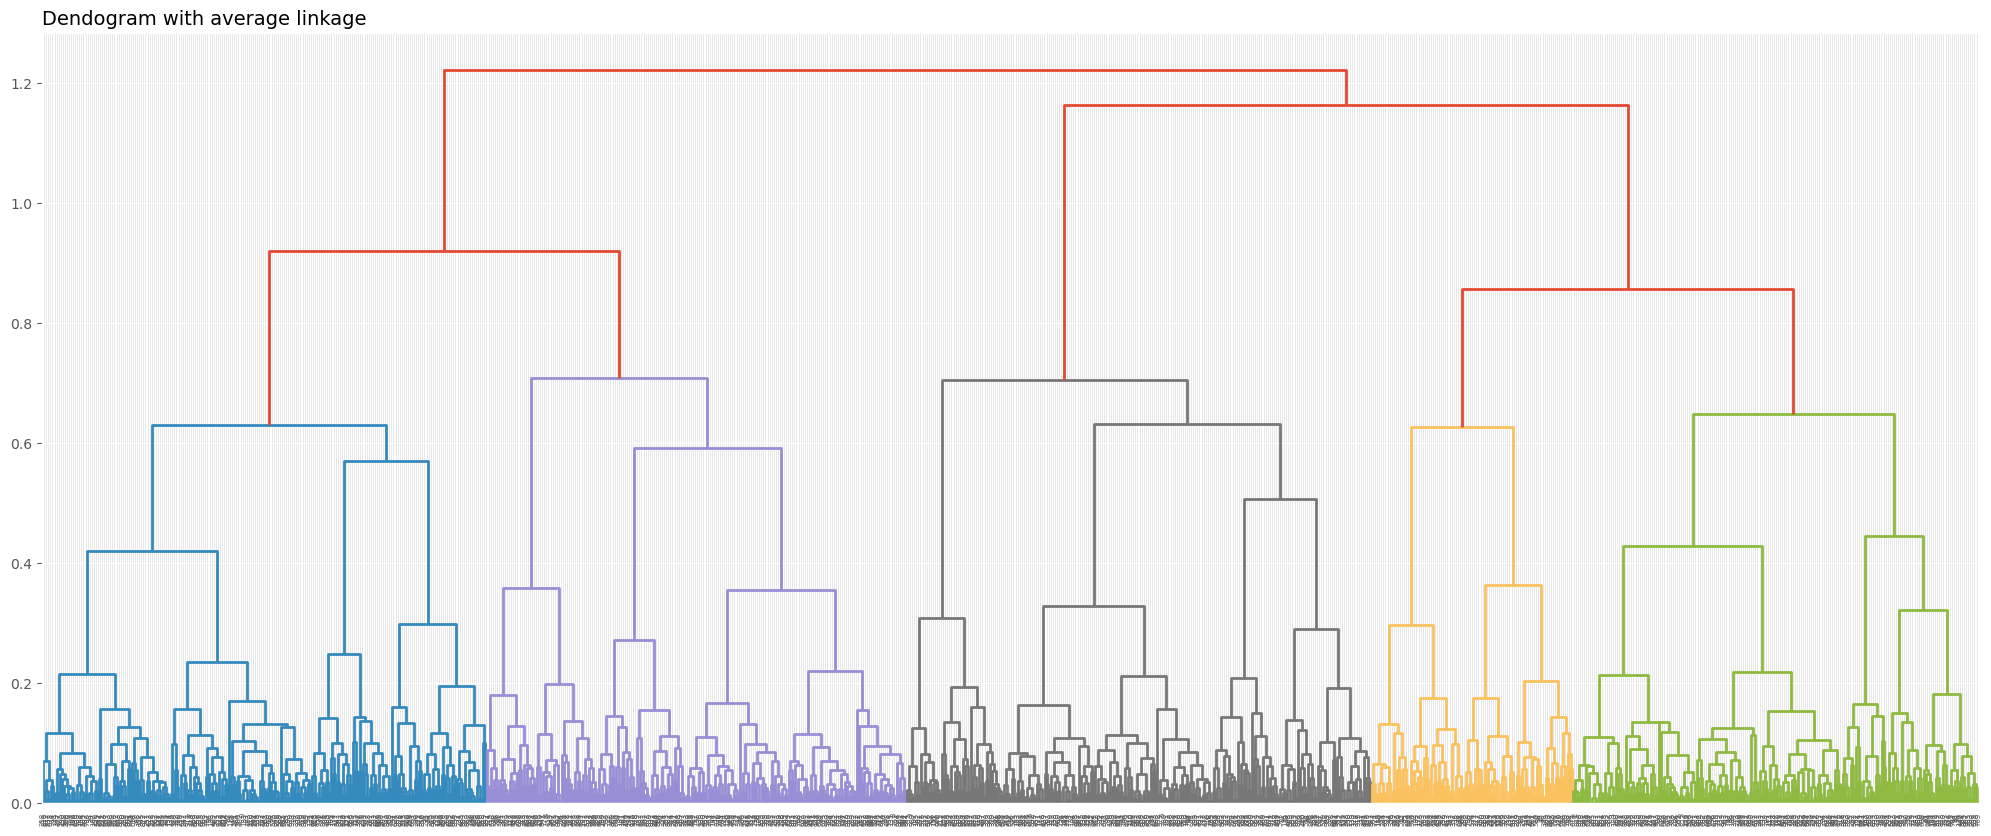

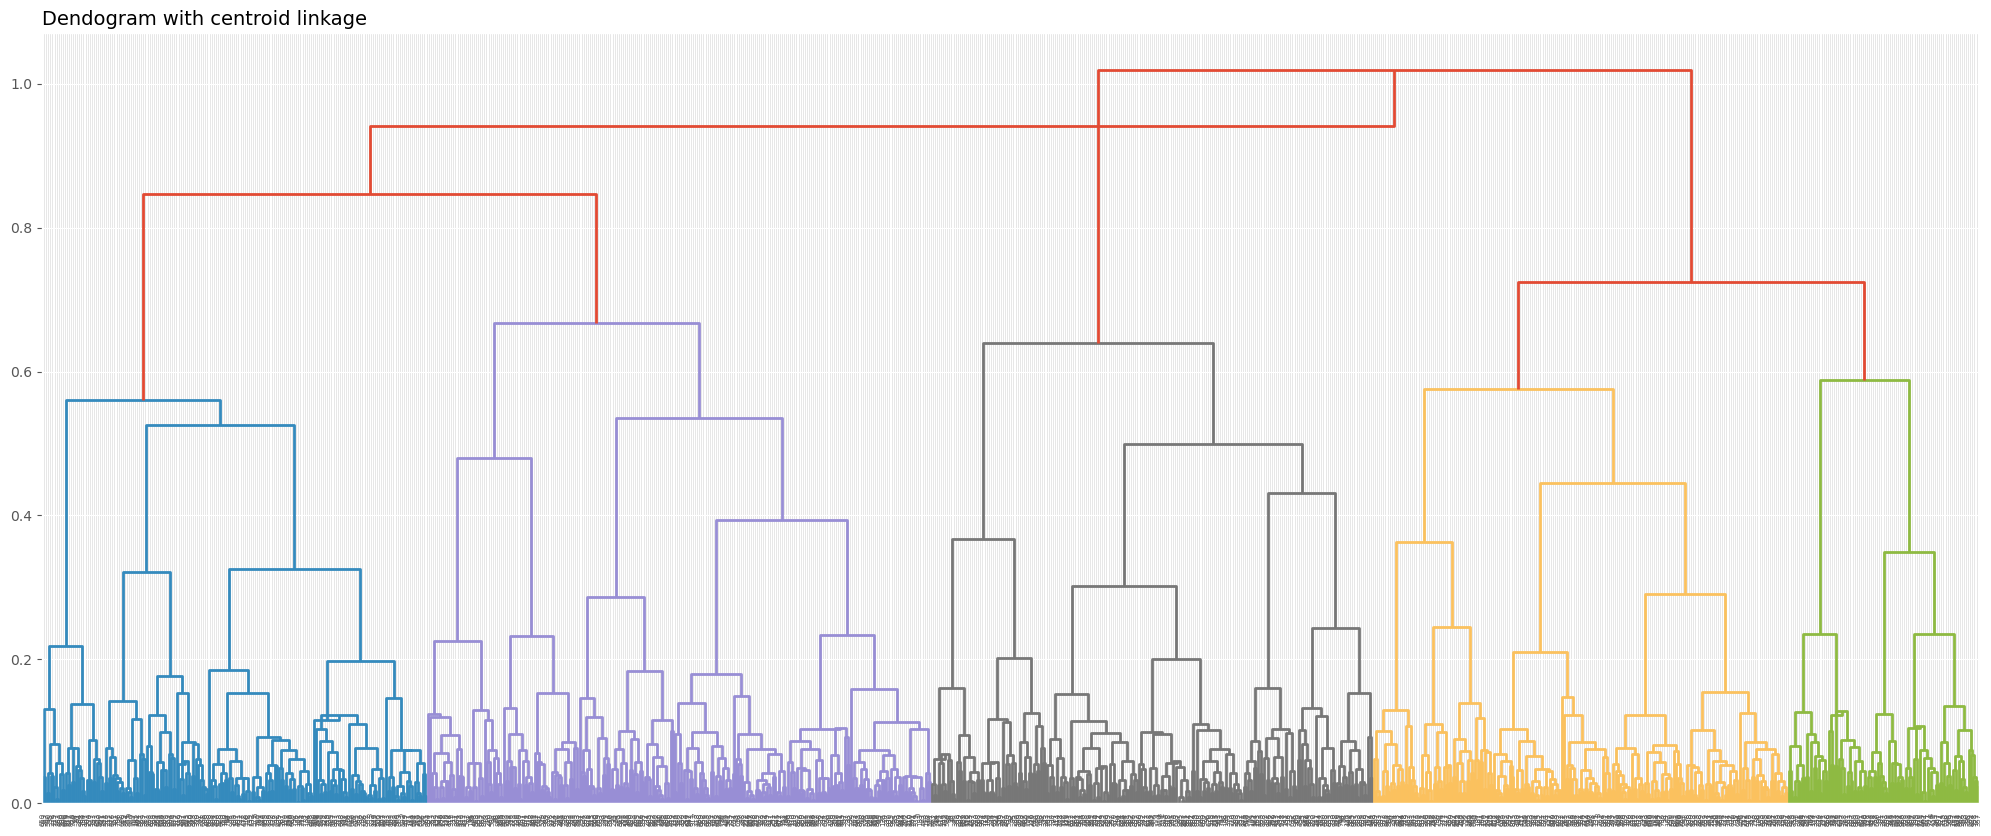

In [33]:
plot_dendograms(X)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> Interpreta el dendrograma y comenta qué criterio de enlace se ha comportado mejor. ¿Por qué?
</div>

En este caso tenemos unos resultados similares a los obtenidos en el caso anterior. El tipo de enlace que mejor se comporta es nuevamente el enlace simple, por la misma razón que antes: al tener dos clusters muy densos y muy separados entre ellos, la distancia mínima de dos elementos de clusters distintos es muy alta entre los dos clusters originales, y por ello la separación en estos dos es muy clara en el primer dendograma. El resto de tipos de enlace dan en este caso unos resultados similares, y en ninguno de ellos vemos el número claro de clusters en los que deberíamos dividir.

<a id="ej2"></a>

## 2. Ejemplo práctico: diseño de redes de transporte (5 puntos)

Imaginemos que un famoso magnate llamado Melon Mask ha culminado su nuevo invento: el hypermegaminiloop. Que revoluciona el transporte urbano, pero de momento es muy muy caro.

El alcalde de Nueva York se ha enterado de su existencia y quiere ser un *early adopter* del proyecto y complementar (que no sustituir) su red de transporte. Para ello se dispone de datos de la [demanda de Uber](https://data.world/data-society/uber-pickups-in-nyc) que con este nuevo método se pretende cubrir.

Se provee de un subconjunto del dato representativo pero de menor tamaño para evitar que su procesado conlleve tiempos de ejecución muy grandes.

In [34]:
df = pd.read_csv('uber_sample.csv')
df.head(3)

Date/Time      Lat      Lon    Base
0   9/16/2014 5:37:00  40.7651 -73.9615  B02764
1  9/21/2014 12:12:00  40.7249 -73.9947  B02764
2  9/22/2014 12:50:00  40.7720 -73.9590  B02598

Visualizamos los datos para ver donde hay mayor concentración de peticiones y facilitar el posterior análisis de los datos. ¿Puedes localizar *Central Park*?

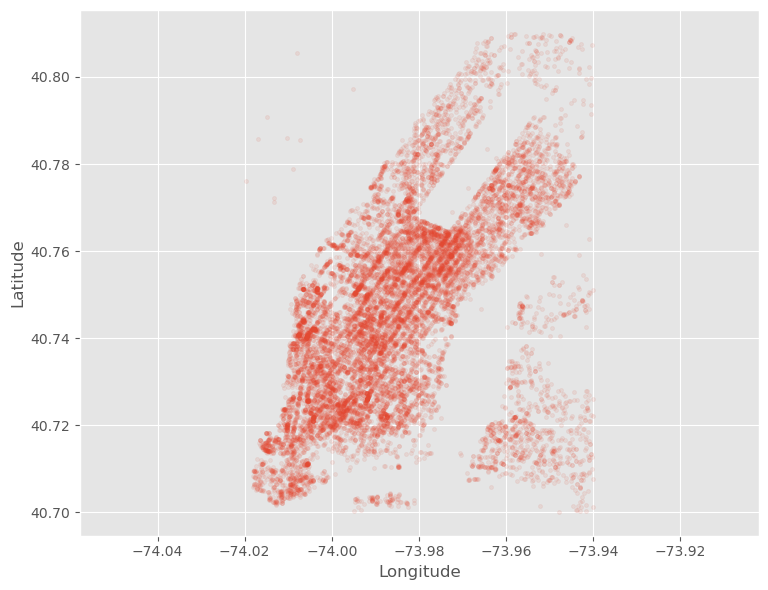

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.scatter(df['Lon'], df['Lat'], s=8, alpha=.1)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.axis('equal')
plt.tight_layout()

### 2 a. Localización de las paradas: clustering

La primera parte del diseño de la red de transporte es situar las futuras paradas. Para ello tendrás que identificar entre 100 y 200 lugares del mapa (aproximación aportada por el departamento de transporte de la ciudad) con alta concentración de demanda.

Puedes elegir cualquier algoritmo de clustering para este cometido, pero recuerda que tendrás que justificar la respuesta para la propuesta de proyecto.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>
elige y aplica una técnica de clustering para encontrar entre 100 y 200 grupos de puntos.
</div>

Elegimos un algoritmo basado en densidad porque es nuestro principal objetivo, el de detectar zonas con alta densidad de solicitudes.

Eligiríamos un algoritmo como k-means si nuestro objetivo fuese, por ejemplo, el de dividir en zonas toda la superficie de Nueva York para su total cobertura, pero no es el caso.

En primer lugar, probamos con DBSCAN, y ajustamos los parámetros para que nos de un resultado de clusters en el rango deseado.

In [36]:
X = df[['Lon','Lat']].values
X.shape

(16017, 2)

In [37]:
db = cluster.DBSCAN(eps=0.0005, min_samples=14)
classes_db = db.fit_predict(X)
print(f'Number of clusters found with DBSCAN is {len(set(classes_db))-1}')

Number of clusters found with DBSCAN is 140


¡Perfecto! Parece que tendremos 140 paradas para el nuevo hypermegaminiloop.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>
visualiza los grupos encontrados dotando de color a los puntos en base al cluster al que pertenecen. Puedes utilizar el colormap 'tab20' para tener una paleta de color discreta y amplia que permita visualizar mejor los resultados.
</div>

In [38]:
def plot_high_density_zones(X, y):
    fig, ax = plt.subplots(figsize=(10,8))
    outliers = X[y==-1]
    clustered = X[y!=-1]
    clustered_classes = y[y!=-1]
    sns.scatterplot(x=outliers[:,0], y=outliers[:,1], color='#777777', alpha=0.1, s=8, ax=ax, legend=False)
    sns.scatterplot(x=clustered[:,0], y=clustered[:,1], hue=clustered_classes, alpha=0.2, palette='tab20', ax=ax, legend=False)
    ax.set_title(f'High density zones: {len(set(y))-1}', fontsize=14, loc='left')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.axis('equal')
    plt.show()

Visualizamos los clusters que hemos seleccionado como zonas de alta concentración. Los marcamos en colores frente al resto de puntos que quedan en gris.

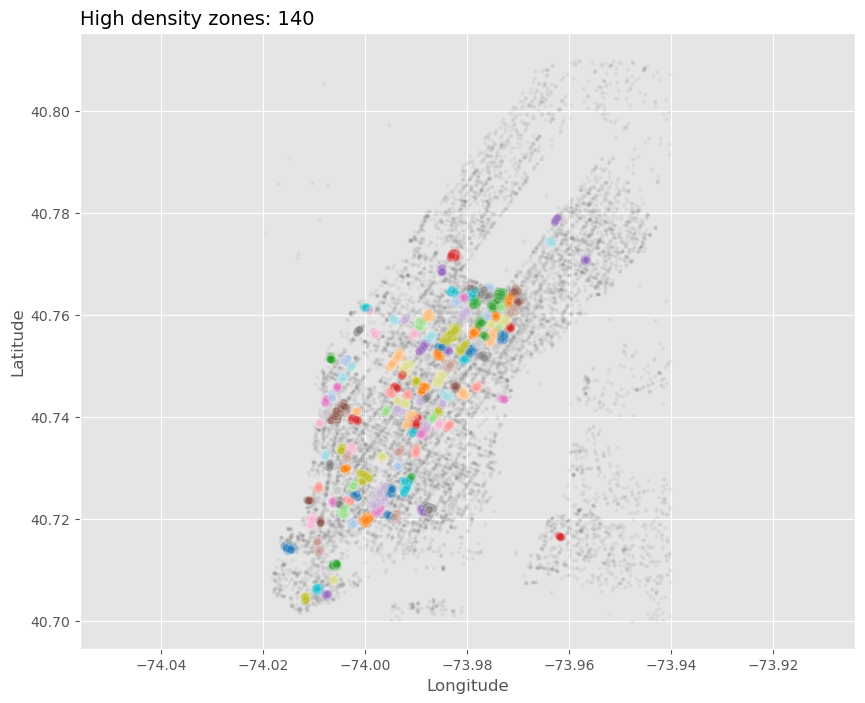

In [39]:
plot_high_density_zones(X, classes_db)

Vemos que ma gran mayoría de puntos de alta demanda se encuentran en Midtown y Lower Manhattan.

Parece que los vecinos de los vecinos de Brooklyn van a tener suerte y disfrutar de la velocidad del nuevo hypermegaminiloop; con una sóla parada, eso sí. Lamentablemente, los habitantes de Nueva Jersey se quedan nuevamente sin un transporte decente que los conecte con el otro lado del Hudson.

Realizamos la misma prueba con otro algoritmo de clustering, OPTICS, que tiene un comportamiento similar a DBSCAN y está basado en éste, pero cuyo funcionamiento es más sencillo al no tener que especificar uno de los parámetros de DBSCAN.

In [40]:
op = cluster.OPTICS(min_samples=20)
classes_op = op.fit_predict(X)
print(f'Number of clusters found with OPTICS is {len(set(classes_op))-1}')

Number of clusters found with OPTICS is 160


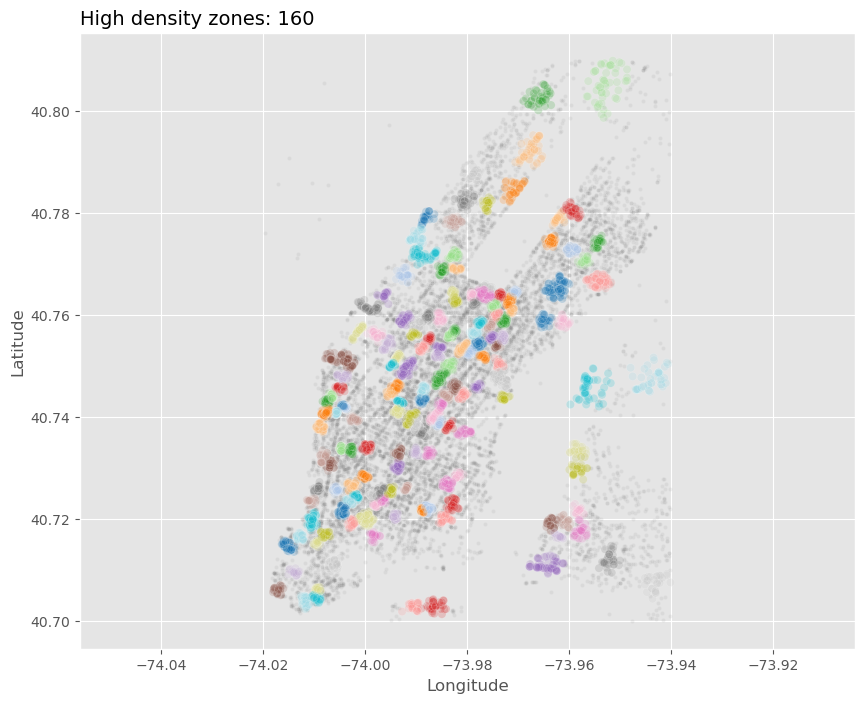

In [41]:
plot_high_density_zones(X, classes_op)

Vemos como en este caso, pese a la ventaja evidente de hacer el clustering más cómodo por tener que especificar un parámetro menos (sólo tenemos que especificar *min_samples*), los resultados que obtenemos son peores porque tenemos zonas identificadas cuya densidad de puntos es claramente inferior (ver, por ejemplo, el cluster verde de Harlem). Sí, quizás los habitantes de Brooklyn, Queens y Upper Manhattan estarían más contentos, pero hemos sido contratados para un único objetivo y es el de maximizar beneficios, no para hacer de ONG. Nos quedamos por lo tanto con el caso anterior, realizando el clustering con DBSCAN.

<div class="alert alert-block alert-info">
<strong>Análisis:</strong>
    De cara a la redacción de la propuesta de proyecto, ¿por qué has elegido este método de agrupamiento?
</div>

Nos centramos en la resolución del problema con algoritmos de clustering basados en densidad, porque es precisamente ésto lo que nos piden, el identificar zonas con gran concentración. Por ello, el uso de estos algoritmos es especialmente adecuado en este caso. Además, no nos piden un número concreto de clusters, sino un rango aproximado entre 100 y 200. Estos algoritmos no nos van a permitir especificar un número concreto de clusters, pero sí nos permiten ajustar los parámetros para obtener el número aproximado deseado. Por último, vemos que nos devuelve una gran cantidad de puntos clasificados coomo *outliers* y no asignados a ninguno de los clusters, pero en nuestro caso esto no es un problema en absoluto, ya que no se nos pide dar servicio al mayor número de usuarios, ni cubrir la mayor área.

Por otro lado, hemos probado dos algoritmos basados en densidad y nos hemos quedado con DBSCAN por lo expuesto anteriormente.

### 2 b. Análisis de grupos y preparación de datos

Antes de continuar con el diseño de la red de transporte hay que validar que los grupos tienen sentido.

Lo primero es estimar la densidad de cada grupo encontrado:

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>
calcula para cada cluster su área:
    <br/>
    1. Puedes simplificarla de la siguiente manera: (lat_max - lat_min) * (lon_max - lon_min), cuidado con los valores negativos, de los puntos que pertenecen al grupo.
    <br/>
    2. También calcula el número de puntos que pertenecen a cada grupo.
    <br/>
    3. Calcula el siguiente ratio: número de puntos (2) por área cubierta (1) de cada cluster.
    <br/>
    Por último, visualiza para cada cluster el resultado de este cálculo (3) en un diagrama de barras.
</div>

Realizamos las transformaciones solicitadas. Tomamos la decisión de multiplicar el área calculada como grados al cuadrado por 10e6 para que salgan valores no tan pequeños. Esto por supuesto también se verá afectado en la densidad, en la que saldrán valores no tan grandes.

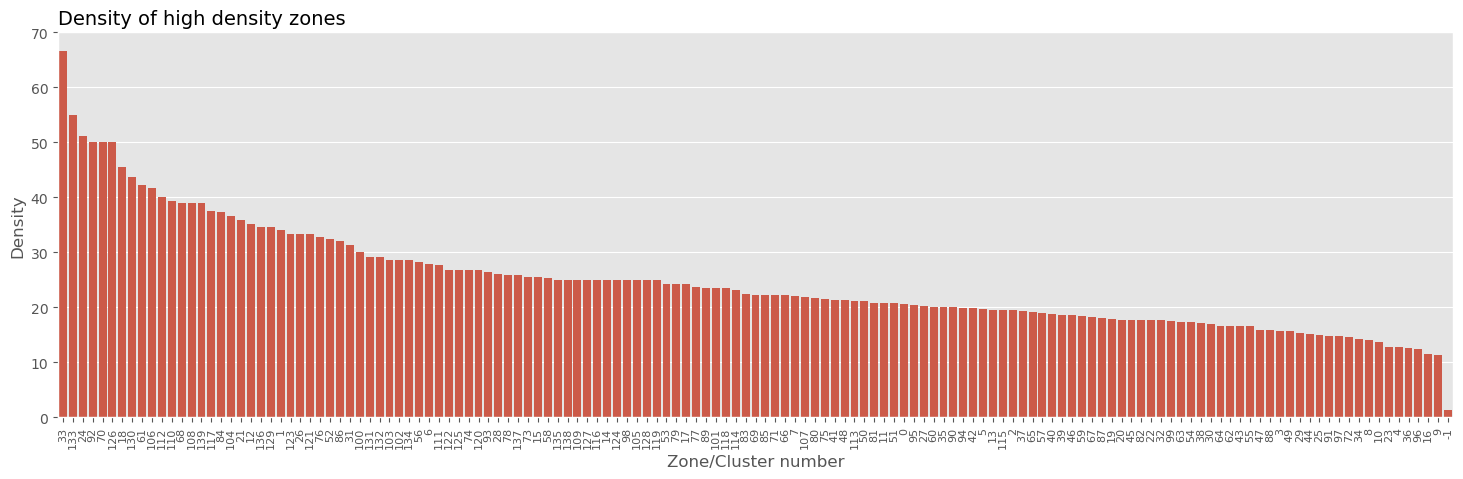

In [42]:
def create_cluster_df(df):
    df_clusters = df.groupby('Cluster').agg([np.min, np.max, 'count'])
    df_clusters.columns = list(map('_'.join, df_clusters.columns.values))
    df_clusters = df_clusters.drop('Lon_count', axis=1).rename({'Lat_count':'Count'}, axis=1)
    df_clusters['Area'] = (df_clusters[('Lat_amax')] - df_clusters[('Lat_amin')]) * (df_clusters[('Lon_amax')] - df_clusters[('Lon_amin')]) *1000000
    df_clusters['Density'] = df_clusters['Count'] / df_clusters['Area']
    df_clusters['ClusterNo'] = df_clusters.index
    df_clusters = df_clusters.sort_values('Density', ascending=False).reset_index(drop=True)
    return df_clusters # Return clusters ordered by density
    

def plot_clusters_density(df):
    fig, ax = plt.subplots(figsize=(18,5))
    sns.barplot(x=df.index, y=df['Density'], color='#E24A33', ax=ax)
    ax.tick_params(axis='x', rotation=90, labelsize=8)
    ax.set_title('Density of high density zones', fontsize=14, loc='left')
    ax.set_xticklabels(df['ClusterNo'])
    ax.set_xlabel('Zone/Cluster number')
    plt.show()

    
# We create dataframe with 
df_full = pd.DataFrame({'Lon':X[:,0], 'Lat':X[:,1], 'Cluster':classes_db})

# We create clusters DataFrame
df_clusters = create_cluster_df(df_full) 

# Plot density of zones
plot_clusters_density(df_clusters)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong>
    ¿Observas alguna situación sospechosa? Analízala y, si es necesario, limpia el dato para las siguientes fases.
</div>

Debido al altoritmo que hemos utilizado (DBSCAN), obtenemos una clase que realmente engloba a todos los elementos del dataset que no se clasifican en ningún cluster y que por lo tantos son *outliers*. En nuestro caso, a esta clase pertenecen la mayoría de elementos del dataset y están repartidos por todo el mapa, por lo que el área que abarca es muy grande y por lo tanto la densidad de esta clase de valores *outliers* es muy baja, como se puede apreciar en la gráfica anterior en el último cluster con la etiqueta -1. Eliminamos esta clase, porque realmente no representa un cluster deseado.

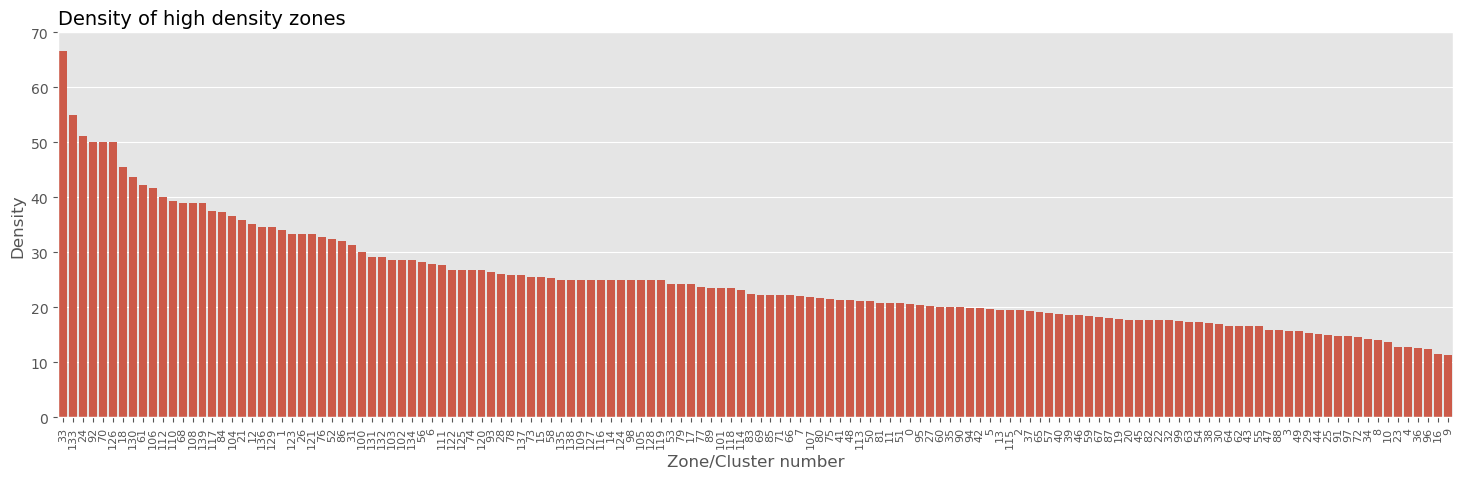

In [43]:
df_clusters = df_clusters[df_clusters['ClusterNo'] != -1]
plot_clusters_density(df_clusters)

### 2 c. Diseño de la red de transporte

Debido a que la tecnología es muy nueva y cara, tenemos el mandato de hacer un diseño que minimice la extensión de la red tratando de dar cobertura al mayor número de peticiones posibles.

Para ello se pueden usar distintas estrategias. Entre ellas la familia *MST* o [*Minimum Spanning Tree*](https://en.wikipedia.org/wiki/Minimum_spanning_tree), con algoritmos como el de [*Kruskal*](https://en.wikipedia.org/wiki/Kruskal%27s_algorithm) o *Prim*. El algoritmo de *Kruskal* tiene la ventaja de ser muy rápido por ser *greedy* o voraz (subóptimo) y, además, evita ciclos. Un beneficio extra, ya que en nuestro caso establecería enlaces redundantes, los cuales queremos evitar por el elevado coste.

Los pasos son los siguientes:
1. Preparar los datos para el grafo.
2. Aplicar el algoritmo de Kruskal.
3. Analizar los resultados y decidir el diseño final de la red.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>
crea un dataframe en el que haya una fila por cluster y ésta contenga: <b>id</b> del cluster (numérico), <b>latitud</b> y <b>longitud</b> (representativa del cluster), y <b>número de puntos</b> pertenecientes al cluster.
</div>

In [44]:
df_clusters.head()

Lon_amin  Lon_amax  Lat_amin  Lat_amax  Count  Area    Density  ClusterNo
0  -74.0091  -74.0084   40.7386   40.7389     14  0.21  66.666667         33
1  -73.9992  -73.9988   40.7606   40.7611     11  0.20  55.000000        133
2  -74.0068  -74.0063   40.7511   40.7520     23  0.45  51.111111         24
3  -74.0058  -74.0052   40.7456   40.7461     15  0.30  50.000000         92
4  -74.0114  -74.0103   40.7235   40.7239     22  0.44  50.000000         70

Para tener una latitud y longitud representativa del cluster, tomaremos el punto medio entre la máxima y la mínima que tengamos entre los puntos del cluster para ambas latitud y longitud. A continuación nos quedamos sólo con los datos que nos interesan.

In [45]:
df_transport = df_clusters.copy()
for col in ['Lon', 'Lat']:
    df_transport[col] = (df_transport[col+'_amin']+df_transport[col+'_amax'])/2
df_transport = df_transport.drop(['Lat_amin', 'Lat_amax', 'Lon_amin', 'Lon_amax', 'Density', 'Area'], axis=1)
df_transport = df_transport.set_index('ClusterNo').sort_index()
df_transport.head()

Count      Lon      Lat
ClusterNo                         
0             37 -73.9730  40.7558
1             49 -74.0037  40.7511
2             42 -73.9884  40.7454
3             79 -73.9749  40.7558
4            120 -73.9741  40.7629

In [46]:
df_transport.shape

(140, 3)

Para crear el grafo no dirigido (si 1 está conectado con 2 se asume la dirección inversa) a partir del cual el algoritmo de *Kruskal* seleccionará los enlaces es necesario indicarle las posibles aristas del grafo.

Para crear el grafo simplemente hay que instanciar la clase `Graph` del módulo *kruskal* que hemos modificado a partir de [aquí](https://www.pythonpool.com/kruskals-algorithm-python/). Indicando en el parámetro `vertex` de su constructor el id más alto de cluster +1. Posteriormente se pueden añadir aristas al grafo indicando primero los dos ids de clusters que une el tramo y por último su peso que viene indicado por la definición de *weight* más adelante.

Por último, se calcula el resultado de *Kruskal* sobre el grafo haciendo una llamada al método `kruskal`, que también dispone de un parámetro `max_links` si sólo deseamos que se generen tantos tramos como se indiquen (útil más adelante).

Un ejemplo concreto sería el siguiente:

```
g = kruskal.Graph(vertex=5)
g.add_edge(0, 1, 8)
...
g.add_edge(3, 4, 7)
g.kruskal()
```

Debido al alto coste es necesario justificar la construcción de cada tramo del *hypermegaminiloop*, por lo que vamos a emplear una métrica que pese (*weight*) cada tramo (unión entre 2 clusters cualquiera $i$ y $j$):

$$weight(i, j) = -\frac{n_i+n_j}{dist(i, j)}$$

Donde:
 - $n_i$ es el número de puntos del cluster $i$, de la misma manera $n_j$ es el número de puntos del cluster $j$.
 - $dist(i, j)$ es la distancia geográfica en km entre el centro del cluster $i$ y el cluster $j$.
 
La distancia geográfica entre 2 puntos cualesquiera no es la distancia euclídea, puesto que la tierra tiene curvatura. Para ello puedes usar el módulo [haversine](https://pypi.org/project/haversine/) (ya importado como *hs* al inicio de la PEC).

Por último, resaltar que el peso final es negativo porque el algoritmo de *Kruskal* ve este peso como un coste que trata de minimizar. Por nuestra parte, deseamos incentivar que a medida que más alto sea el ratio descrito más atractivo le sea a *Kruskal*, por eso se hace negativo.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>
crea un grafo siguiendo el código de ejemplo en el que aparezcan todos los pares de clusters posibles (no hace falta repetir los pares porque se trata de un grafo no dirigido donde A-B también equivale a B-A), donde el peso (último parámetro del método add_edge) se calcule tal y como se describe en la fórmula de weight.
</div>

Para hacer el grafo utilizaremos la función combinations de itertools, que precisamente nos proporciona un iterable con todas las combinaciones posibles entre los elementos de otro iterable (en nuestro caso, los IDs de los clusters), sin repeticiones.

In [47]:
from itertools import combinations


def create_graph(df, max_links=None):
    df = df.reset_index().copy()
    g = kruskal.Graph(vertex=df.index.max()+1)
    for i, j in combinations(df.index, 2):
        distance = hs.haversine((df.loc[i, 'Lat'], df.loc[i, 'Lon']), (df.loc[j, 'Lat'], df.loc[j, 'Lon']))   
        weight = -(df.loc[i, 'Count'] + df.loc[j, 'Count']) / distance
        g.add_edge(i, j, weight)
    return g.kruskal(max_links=max_links)

Comprobamos el resultado obtenido variando el número de *max_links* e introducinedo en el grafo todos los puntos de alta densidad.

In [48]:
df_links = create_graph(df_transport)
display(df_links.head())
print(f'Size without max_links is {df_links.shape[0]}')

id_a  id_b       weight
0     9    75 -1343.268861
1    10    35 -1071.448823
2     4    82  -848.050984
3     4    85  -838.196171
4     9    80  -837.480675

Size without max_links is 139


In [49]:
df_links = create_graph(df_transport, 20)
display(df_links.head())
print(f'Size with max_links=20 is {df_links.shape[0]}')

id_a  id_b       weight
0     9    75 -1343.268861
1    10    35 -1071.448823
2     4    82  -848.050984
3     4    85  -838.196171
4     9    80  -837.480675

Size with max_links=20 is 20


<div class="alert alert-block alert-info">
<strong>Implementación:</strong>
aplica el algoritmo de Kruskal llamando al método kruskal del grafo variando el número de ejes en función de tu criterio (compromiso entre extensión y coste).
</div>

El algoritmo kruskal devuelve un DataFrame con todos los enlaces ordenados por *weight* decreciente. Cambiar el valor de *max_links* lo único que hace es truncar este DataFrame, de forma que devuelve los n enlaces de mayor importancia según le métrica que hemos definido, como podemos comprobar en las tablas anteriores. Por lo tanto, si limitamos *max_links* introduciendo todos los vértices en el grafo (zonas de alta concentración seleccionadas), nos quedamos con los mejores enlaces entre éstos, pero no estarán todos los puntos conectados entre ellos, y por lo tanto nos queda una red no totalmente conectada. 

Como no parece muy apropiado montar una red de transporte en la que no todas las paradas queden conectadas entre ellas, se toma como decisión de diseño que esto no ocurra. Para ello, lo que hacemos es ordenar los clusters por su número de usuarios y quedarnos con los n mayores, que serán los vértices del grafo, y con ellos realizar la conexión completa del grafo con el algoritmo kruskal. Realizamos este pasos para distinto número de clusters servidos y representamos en una gráfica el peso acumulado total frente al número de paradas.

In [50]:
df_transport = df_transport.sort_values('Count', ascending=False).reset_index()
df_transport.head()

ClusterNo  Count       Lon       Lat
0         10    177 -74.00515  40.74105
1          9    149 -73.99710  40.72440
2          4    120 -73.97410  40.76290
3         16    111 -73.98330  40.75610
4         23    107 -73.99400  40.75130

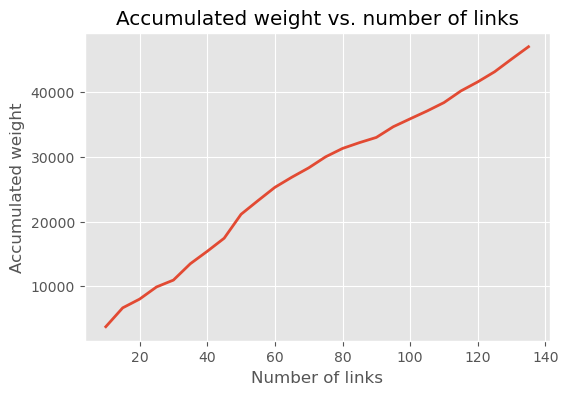

In [51]:
n_clusters_list = list(range(10, df_transport.shape[0], 5))
cum_weight = []
for n_clusters in n_clusters_list:
    df_links = create_graph(df_transport.iloc[:n_clusters+1,])
    cum_weight.append(df_links['weight'].abs().sum())
    
fig, ax = plt.subplots(figsize=(6,4))
sns.lineplot(x=n_clusters_list, y=cum_weight)
ax.set_xlabel('Number of links')
ax.set_ylabel('Accumulated weight')
ax.set_title('Accumulated weight vs. number of links')
plt.show()

En base al gráfico anterior, vemos como conforme vamos añadiendo más vértices al grafo (paradas de nuestro sistema de transporte) con sus correspondientes enlaces, la mejora acumulada cada vez es mayor. No tenemos un criterio único para decidir el número de enlaces a realizar, pero tomamos la decisión de realizar 80 enlaces entre clusters, número a partir del cual parece que se ralentiza el aumento de la mejora acumulada.

In [52]:
n_clusters = 80
df_transport = df_transport.iloc[:n_clusters+1,]
df_links = create_graph(df_transport)

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>
visualiza los centros de los clusters indicando su importancia (por ejemplo incrementando su diámetro o cambiar su color en función del número de puntos que contiene) y sus enlaces indicando también su importancia (mediante su grosor o transparencia) producidos por la salida de Kruskal.
</div>

Para dibujar los enlaces tendremos que hacer un join entre los dataframes en los que guardamos los pares de cluster IDs y en los que guardamos la posición del cluster como el punto medio de sus elementos extremos.

In [53]:
df_transport.head()

ClusterNo  Count       Lon       Lat
0         10    177 -74.00515  40.74105
1          9    149 -73.99710  40.72440
2          4    120 -73.97410  40.76290
3         16    111 -73.98330  40.75610
4         23    107 -73.99400  40.75130

In [54]:
df_links_full = df_links.merge(df_transport, left_on='id_a', right_index=True)
df_links_full = df_links_full.merge(df_transport, left_on='id_b', right_index=True, suffixes=['_a', '_b'])
df_links_full = df_links_full.drop(['Count_a', 'Count_b'], axis=1)
df_links_full.head()

id_a  id_b       weight  ClusterNo_a    Lon_a    Lat_a  ClusterNo_b  \
0      1    47 -1343.268861            9 -73.9971  40.7244           75   
4      1    48  -837.480675            9 -73.9971  40.7244           80   
11     1    39  -633.155592            9 -73.9971  40.7244           72   
19     1     5  -486.710418            9 -73.9971  40.7244           58   
27     1    12  -417.630091            9 -73.9971  40.7244           36   

       Lon_b     Lat_b  
0  -73.99860  40.72480  
4  -73.99505  40.72555  
11 -73.99745  40.72180  
19 -73.99185  40.72640  
27 -73.99995  40.72825

In [55]:
df_links_full.shape

(80, 9)

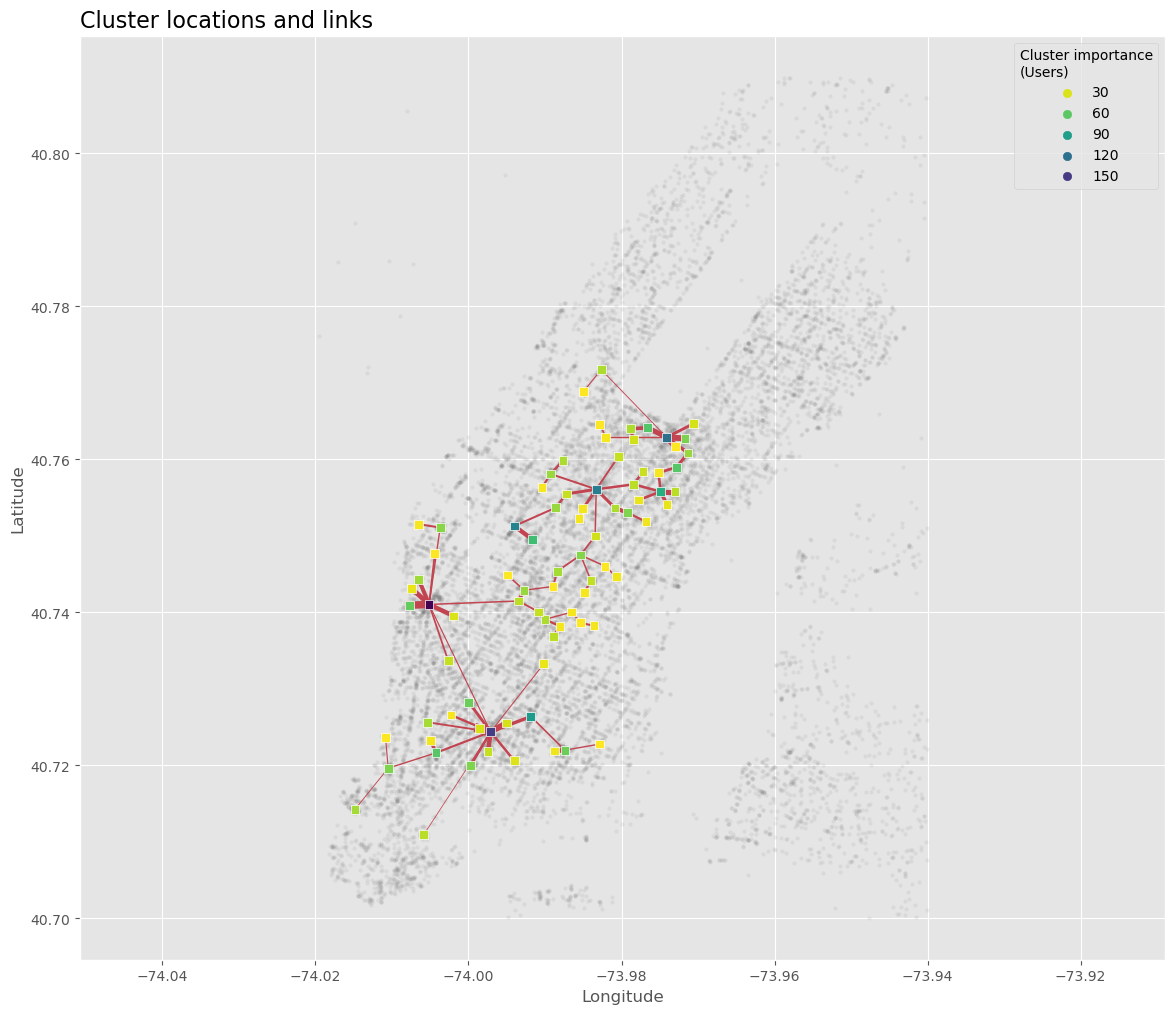

In [56]:
# Create fig and axis
fig, ax = plt.subplots(figsize=(14,12))  
# Plot all original points so we have an idea of the problem
sns.scatterplot(x='Lon', y='Lat', data=df_full, alpha=0.1, s=10, color='#777777', ax=ax)
# Plot selected clusters coloured by cluster importance (number of clients in area)
sns.scatterplot(x='Lon', y='Lat', hue='Count', data=df_transport, marker='s', s=40, palette='viridis_r', ax=ax, **{'zorder':10})
plt.legend(title='Cluster importance\n(Users)')
# Plot links between clusters according to kruskal algorithm
for i in range(df_links_full.shape[0]):
    x = [df_links_full.loc[i, 'Lon_a'], df_links_full.loc[i, 'Lon_b']]
    y = [df_links_full.loc[i, 'Lat_a'], df_links_full.loc[i, 'Lat_b']]
    sns.lineplot(x=x, y=y, lw=df_links_full.loc[i, 'weight']*0.005, color='#C24450', ax=ax, legend=False)
ax.set_title('Cluster locations and links', loc='left', fontsize=16)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.axis('equal')
plt.show()

En el gráfico tenemos representados:
* Todos los puntos originales de solicitudes de clientes en gris de fondo.
* Cuadrados en el punto medio de cada cluster detectado con alta densidad de clientes a los que vamos a dar servicio. El color de cada cuadrado indica el número de puntos (clientes) en ese cluster.
* Los enlaces entre esos clusters más importantes. El grosor de la línea del enlace representa el peso del enlace, calculado como un compromiso entre el número de usuarios a los que da servicio (entre sus dos estaciones extremas) y su coste (por distancia entre ellos). Por lo tanto, a mayor grosor mayor "importancia" estratégica tiene dicho enlace.

Parece que finalmente clientes de Brooklyn se quedarán sin el *hypermegaminiloop*, ya que nuestra red no llegará.

<div class="alert alert-block alert-info">
<strong>Análisis:</strong>
    Además del método de Kruskal ¿se te ocurren o conoces otros métodos que podrían mejorar la solución? Descríbelo brevemente.
</div>

El algoritmo de Kruskal tiene como objetivo encontrar el árbol de cobertura mínimo de un grafo no dirigido, como es nuestro caso. De esta manera, obtendremos los mejores enlaces a realizar (con menor coste) para que todos los puntos del grafo estén conectados entre si. Hay otras alternativas al algoritmo Kruskal, como el algoritmo de Prim o algoritmo de Dijkstra, pero que deberían llegar al mismo resultado, sólo que con una complicación computacional que puede ser distinta.

Por otro lado, ya hemos realizado la mejora sobre el planteamiento inicial de realizar la conexión del grafo sólo sobre las estaciones con más clientes, para que éstas queden totalmente conectadas. De no haber realizado esta modificación, y realizando el grafo con todos los clusters detectados para luego quedarnos sólo con los enlaces con mayor peso, nos quedamos con los enlaces más importantes que cubran todos los clusters, pero no todas las estaciones quedan enlazadas entre si, lo cual no parece muy inteligente para una red nueva de transporte.

### 2 d. [OPCIONAL] Visualización sobre el mapa

Para observar cómo queda el proyecto sobre el plano se puede usar la librería [smopy](https://github.com/rossant/smopy) que se apoya en [OpenStreetMap](https://www.openstreetmap.org/).

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>
visualiza los enlaces indicando su importancia (mediante su grosor o transparencia) producidos por la salida de Kruskal sobre el plano.
</div>

Dibujamos en el mapa las estaciones más importantes (con mayor número de usuarios) y los enlaces que las sevirán. Además, estos enlaces los representamos con un grosor función del peso (tal y como la hemos definido) de dicho enlace.

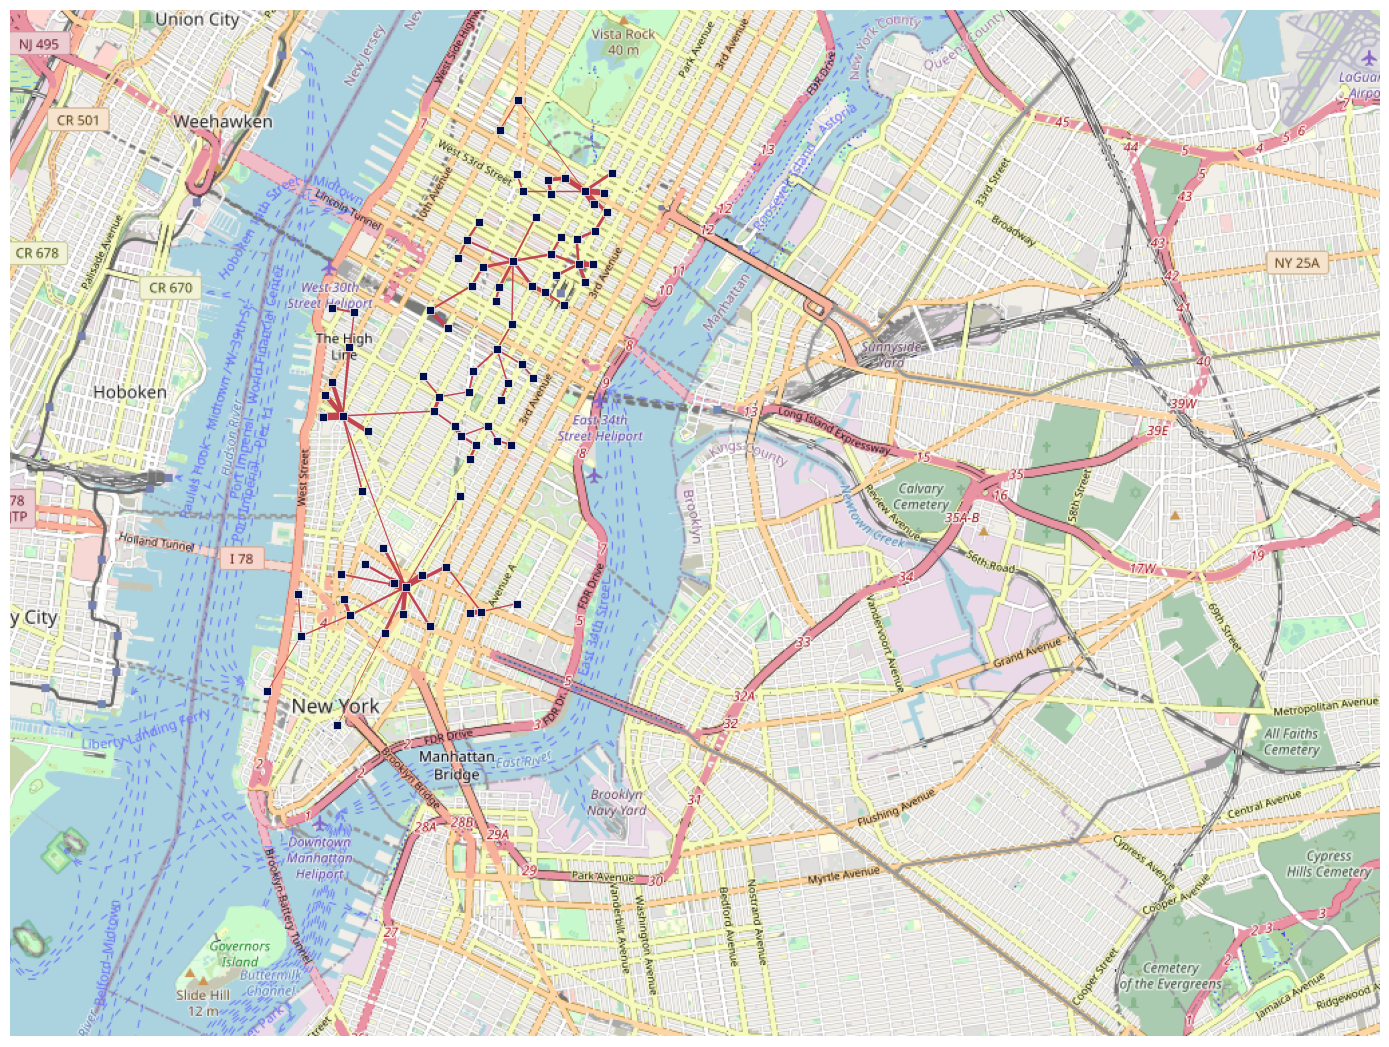

In [57]:
import smopy

linked_clusters = pd.concat([df_links_full['id_a'], df_links_full['id_b']], axis=0).unique()

# Map
map_sm = smopy.Map((40.7, -74, 40.76, -73.9), z=13)
ax = map_sm.show_mpl(figsize=(14, 12))

# Plot served clusters
x, y = map_sm.to_pixels(df_transport.loc[linked_clusters, 'Lat'], df_transport.loc[linked_clusters, 'Lon'])
sns.scatterplot(x=x, y=y, marker='s', s=40, color='#000E4B', ax=ax, **{'zorder':10})

# Plot links between clusters according to kruskal algorithm
for i in range(df_links_full.shape[0]):
    x1, y1 = map_sm.to_pixels(df_links_full.loc[i, 'Lat_a'], df_links_full.loc[i, 'Lon_a'])
    x2, y2 = map_sm.to_pixels(df_links_full.loc[i, 'Lat_b'], df_links_full.loc[i, 'Lon_b'])
    sns.lineplot(x=[x1, x2], y=[y1, y2], lw=df_links_full.loc[i, 'weight']*0.005, color='#C24450',ax=ax, legend=False)
    
plt.show()

## Bibliografía

https://stackoverflow.com/questions/52959063/how-to-change-spot-edge-colors-in-seaborn-scatter-plots

https://seaborn.pydata.org/generated/seaborn.lineplot.html

https://docs.python.org/3/library/itertools.html

https://www.pythonpool.com/kruskals-algorithm-python/

https://en.wikipedia.org/wiki/Kruskal%27s_algorithm

https://stackoverflow.com/questions/56605113/how-to-set-x-axis-ticklabels-in-a-seaborn-plot

https://stackoverflow.com/questions/43770507/seaborn-bar-plot-ordering

https://stackoverflow.com/questions/1195872/when-should-i-use-kruskal-as-opposed-to-prim-and-vice-versa

https://en.wikipedia.org/wiki/Prim%27s_algorithm

https://notebook.community/tomkooij/smopy/examples/example1